# Analysis of subscription for deposits

Project is done by Kristina Denisova and Emmanuel Adu Sarfo

 ___



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit



from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

from sklearn.utils import resample
from imblearn.over_sampling import SMOTE

import pickle


## Data Description

In [2]:
# If you don't want to download data from kaggle
#from google.colab import files
#files.upload() # here choose kaggle.json
#!pip install kaggle
#!mkdir -p ~/.kaggle
#!cp kaggle.json ~/.kaggle/
#!chmod 600 /root/.kaggle/kaggle.json

In [3]:
#!kaggle competitions download -c part-of-your-final-course-grade

In [4]:
#from zipfile import ZipFile, Path

#with ZipFile('part-of-your-final-course-grade.zip', 'r') as zipObj:
   # Get a list of all archived file names from the zip
   #listOfFileNames = zipObj.namelist()
   # Iterate over the file names
   #for fileName in listOfFileNames:
     #zipObj.extract(fileName)

In [5]:
test = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/test_data.csv')
train = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/train_data.csv')

In [6]:
print ('Number of samples: ', len(test))
print ('Number of samples: ', len(train))

Number of samples:  4119
Number of samples:  37069


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37069 entries, 0 to 37068
Data columns (total 22 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             37069 non-null  int64  
 1   job             37069 non-null  object 
 2   marital         37069 non-null  object 
 3   education       37069 non-null  object 
 4   default         37069 non-null  object 
 5   housing         37069 non-null  object 
 6   loan            37069 non-null  object 
 7   contact         37069 non-null  object 
 8   month           37069 non-null  object 
 9   day_of_week     37069 non-null  object 
 10  duration        37069 non-null  int64  
 11  campaign        37069 non-null  int64  
 12  pdays           37069 non-null  int64  
 13  previous        37069 non-null  int64  
 14  poutcome        37069 non-null  object 
 15  emp.var.rate    37069 non-null  float64
 16  cons.price.idx  37069 non-null  float64
 17  cons.conf.idx   37069 non-null 

In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

In [9]:
len(test)/(len(test)+len(train))

0.10000485578323784

The length of train data is 37069 rows and the test data is 4119 rows (about 10 % of the whole banch of data). We have no missing values

*Just not to take a look at kaggle every time*

###Columns
#### **bank client data**:
- **age** - age of customer
- **job** - type of job
- **marital** - marital status
- **education** - highest degree of customer
- **default** - has credit in default?
- **housing** - has housing loan?
- **loan** - has personal loan?
#### **related with the last contact of the current campaign:**
- **contact** - contact communication type
- **month** - last contact month of year
- **day_of_week** - last contact day of the week
- **duration** -  last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
#### **other attributes:**
- **campaign** - number of contacts performed during this campaign and for this client
- **pdays** - number of days that passed by after the client was last contacted from a previous campaign. numeric; 999 means client was not previously contacted\
- **previous** - number of contacts performed before this campaign and for this client
- **poutcome** - outcome of the previous marketing campaign
#### **social and economic context attributes:**
- **emp.var.rate** - employment variation rate - quarterly indicator
- **cons.price.idx** - consumer price index - monthly indicator
- **cons.conf.idx** - consumer confidence index - monthly indicator
- **euribor3m** - euribor 3 month rate - daily indicator
- **nr.employed** - number of employees - quarterly indicator
#### **targeted feature**
- **y** - has the client subscribed a term deposit?

## Data Exploration

In [10]:
train.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y,id
0,31,services,single,high.school,no,yes,no,cellular,may,tue,...,999,0,nonexistent,-1.8,92.893,-46.2,1.291,5099.1,0,33532
1,46,housemaid,divorced,professional.course,unknown,no,no,cellular,jul,tue,...,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0,17783
2,58,technician,married,professional.course,unknown,yes,no,cellular,apr,mon,...,999,0,nonexistent,-1.8,93.075,-47.1,1.405,5099.1,0,29399
3,38,technician,single,university.degree,no,yes,yes,telephone,may,tue,...,999,0,nonexistent,1.1,93.994,-36.4,4.856,5191.0,0,2398
4,37,admin.,married,high.school,no,no,yes,telephone,may,fri,...,999,0,nonexistent,1.1,93.994,-36.4,4.859,5191.0,0,3852
5,34,technician,married,university.degree,no,no,no,telephone,jun,tue,...,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1,0,8154
6,52,admin.,married,university.degree,no,no,yes,cellular,jul,fri,...,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,0,17271
7,48,blue-collar,single,basic.4y,unknown,yes,yes,cellular,may,tue,...,999,0,nonexistent,-1.8,92.893,-46.2,1.344,5099.1,0,30756
8,39,housemaid,married,high.school,no,yes,no,telephone,may,fri,...,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0,5424
9,46,technician,divorced,professional.course,no,yes,no,cellular,jul,tue,...,999,0,nonexistent,1.4,93.918,-42.7,4.961,5228.1,0,14551


In [11]:
test.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,id
0,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,3
1,46,blue-collar,married,basic.6y,unknown,yes,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,18
2,39,management,single,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,20
3,35,technician,married,university.degree,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,26
4,41,admin.,married,university.degree,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,39
5,32,entrepreneur,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,42
6,57,admin.,married,university.degree,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,44
7,35,admin.,married,university.degree,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,49
8,39,housemaid,married,basic.4y,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,52
9,45,services,married,high.school,unknown,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,58


In [12]:
# Count the number of rows for each type
counts = train['y'].value_counts()
counts

0    32891
1     4178
Name: y, dtype: int64

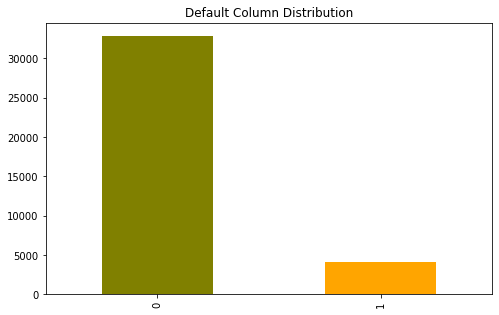

In [13]:
plt.figure(figsize = (8, 5))
counts.plot(kind='bar', color=['olive', 'orange']).set(title='Default Column Distribution')
plt.show();

In [14]:
def calc_prevalence(y_actual):
    # this function calculates the prevalence of the positive class (label = 1)
    return (sum(y_actual)/len(y_actual))

In [15]:
print('prevalence of the positive class: %.3f' % (calc_prevalence(train.y.values)))

prevalence of the positive class: 0.113


The prevalence of the positive class is 11.3% which means that the proportion of people who agreed to a term deposit (positive class) is much less compared to the people who did not. Thus, we have an imbalanced data

## Exploring the data set and unique values

In [16]:
# for each column
for a in list(train.columns):
    
    # get a list of unique values
    n = train[a].unique()
    
    # if number of unique values is less than 30, print the values. Otherwise print the number of unique values
    if len(n)<30:
        print(a)
        print(n)
    else:
        print(a + ': ' +str(len(n)) + ' unique values')

age: 78 unique values
job
['services' 'housemaid' 'technician' 'admin.' 'blue-collar' 'unemployed'
 'retired' 'management' 'student' 'unknown' 'self-employed' 'entrepreneur']
marital
['single' 'divorced' 'married' 'unknown']
education
['high.school' 'professional.course' 'university.degree' 'basic.4y'
 'basic.9y' 'unknown' 'basic.6y' 'illiterate']
default
['no' 'unknown' 'yes']
housing
['yes' 'no' 'unknown']
loan
['no' 'yes' 'unknown']
contact
['cellular' 'telephone']
month
['may' 'jul' 'apr' 'jun' 'nov' 'aug' 'oct' 'dec' 'mar' 'sep']
day_of_week
['tue' 'mon' 'fri' 'thu' 'wed']
duration: 1510 unique values
campaign: 42 unique values
pdays
[999   4   3   6   9  10  15   7  13   8  12   2   5  11  14  26  22   1
  16   0  17  19  20  18  27  25  21]
previous
[0 1 2 3 5 4 7 6]
poutcome
['nonexistent' 'failure' 'success']
emp.var.rate
[-1.8  1.4  1.1 -0.1 -3.4 -3.  -2.9 -1.7 -1.1 -0.2]
cons.price.idx
[92.893 93.918 93.075 93.994 94.465 93.2   93.444 92.431 92.713 92.201
 94.215 92.963 94.0

### Key Observations:

- From the output of the code, we can see that there are roughly the same amount of categorical and numeric values in the columns.

- age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m and nr.employed are numerical variables.

- All the data inputted are non-null values, meaning that we have a value for every column.

- Output (y) has two values: "yes" and "no".

- default, housing and loan have 3 values each (yes, no and unknown).

- We are discarding duration. This attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.

## Feature Engineering

Feature Engineering is classifying features such as numerial and categorical into groups in order to deeply section and analyze the data for results in machine learning algorithms.In this section, we will create features for our predictive model. For each section, we will add new variables to the dataframe and then keep track of which columns of the dataframe we want to use as part of the predictive model features. We will break down this section into numerical and categorical features.

### Numerical Features

These are numeric data. The numerical columns that we will use can be seen below:

In [17]:
cols_num = ['campaign', 'pdays',
       'previous', 'emp.var.rate', 'cons.price.idx','cons.conf.idx', 'nr.employed','age','euribor3m']

In [18]:
train[cols_num].head()

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,age,euribor3m
0,2,999,0,-1.8,92.893,-46.2,5099.1,31,1.291
1,2,999,0,1.4,93.918,-42.7,5228.1,46,4.961
2,2,999,0,-1.8,93.075,-47.1,5099.1,58,1.405
3,1,999,0,1.1,93.994,-36.4,5191.0,38,4.856
4,2,999,0,1.1,93.994,-36.4,5191.0,37,4.859


### Graphical Representation of Numerical Features

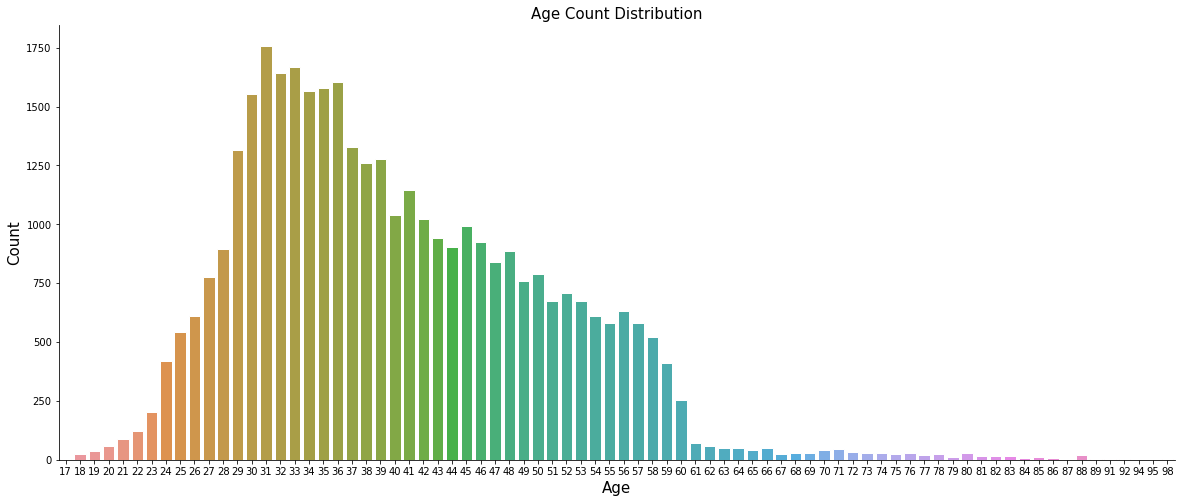

In [19]:
%matplotlib inline
import warnings

warnings.filterwarnings('ignore')
fig, ax = plt.subplots()
fig.set_size_inches(20, 8)
sns.set(style="darkgrid")
sns.countplot(x = 'age', data =  train[cols_num])
ax.set_xlabel('Age', fontsize=15)
ax.set_ylabel('Count', fontsize=15)
ax.set_title('Age Count Distribution', fontsize=15)
sns.despine()

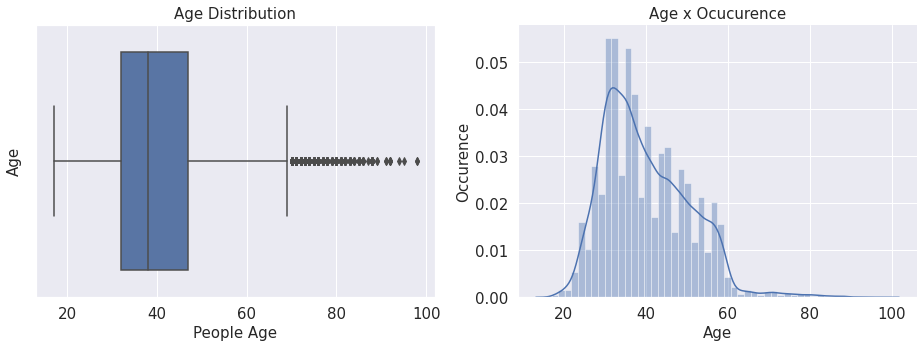

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize = (13, 5))
sns.boxplot(x = 'age', data = train[cols_num], orient = 'v', ax = ax1)
ax1.set_xlabel('People Age', fontsize=15)
ax1.set_ylabel('Age', fontsize=15)
ax1.set_title('Age Distribution', fontsize=15)
ax1.tick_params(labelsize=15)

sns.distplot(train[cols_num]['age'], ax = ax2)
sns.despine(ax = ax2)
sns.set(style="darkgrid")
ax2.set_xlabel('Age', fontsize=15)
ax2.set_ylabel('Occurence', fontsize=15)
ax2.set_title('Age x Ocucurence', fontsize=15)
ax2.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.5)
plt.tight_layout() 

As we can see from this figure the main audience is the group of people 35-45 years old

In [21]:
print("Mean age of customers: %.f" %(train.age.mean()))

Mean age of customers: 40


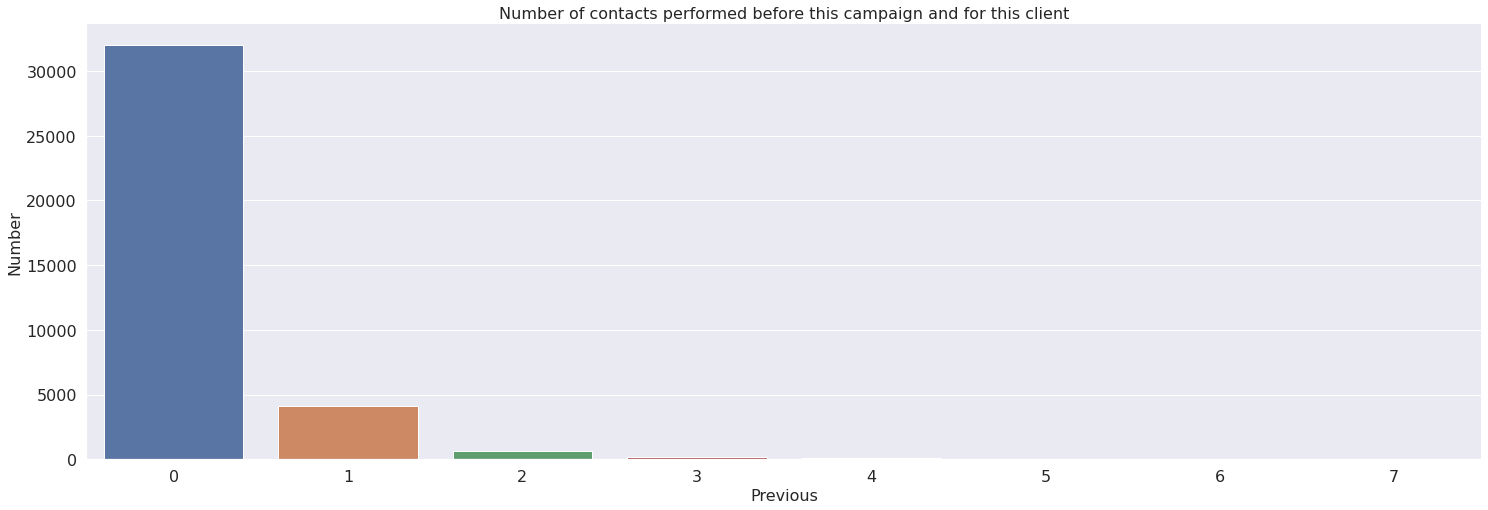

In [22]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.set(style="darkgrid")
sns.countplot(x = 'previous', data = train[cols_num])
ax.set_xlabel('Previous', fontsize=16)
ax.set_ylabel('Number', fontsize=16)
ax.set_title('Number of contacts performed before this campaign and for this client', fontsize=16)
ax.tick_params(labelsize=16)
sns.despine()

As we can see from the figure, in most cases there is no clients or just 1 before the current campaign

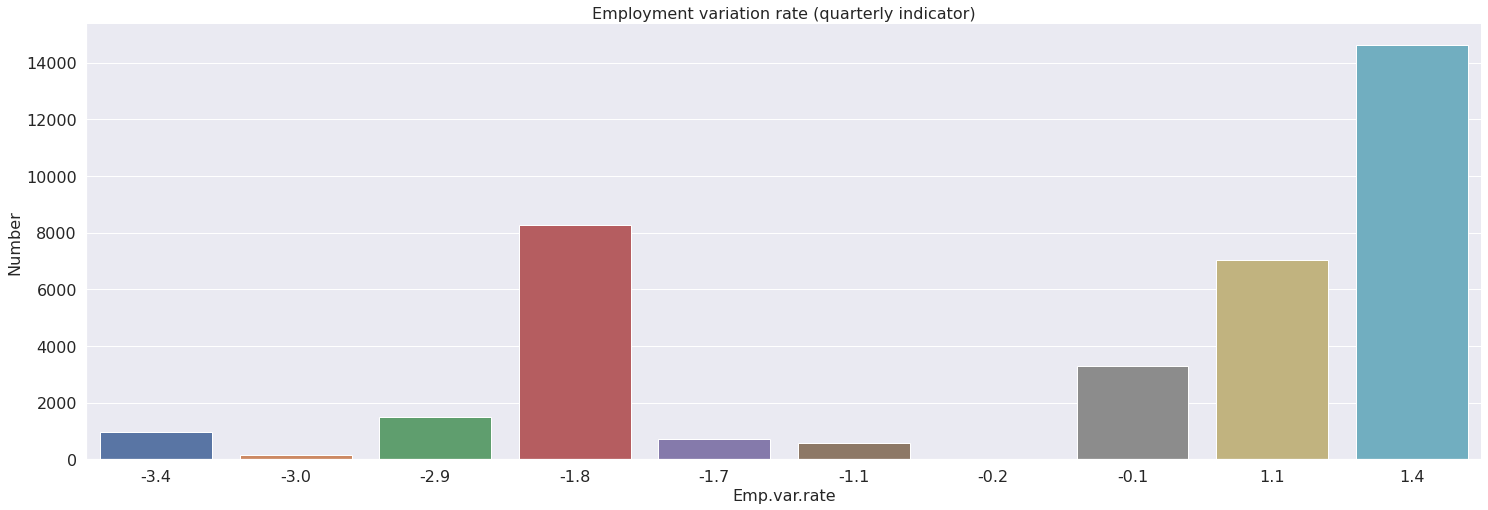

In [23]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.set(style="darkgrid")
sns.countplot(x = 'emp.var.rate', data = train[cols_num])
ax.set_xlabel('Emp.var.rate', fontsize=16)
ax.set_ylabel('Number', fontsize=16)
ax.set_title('Employment variation rate (quarterly indicator)', fontsize=16)
ax.tick_params(labelsize=16)
sns.despine()

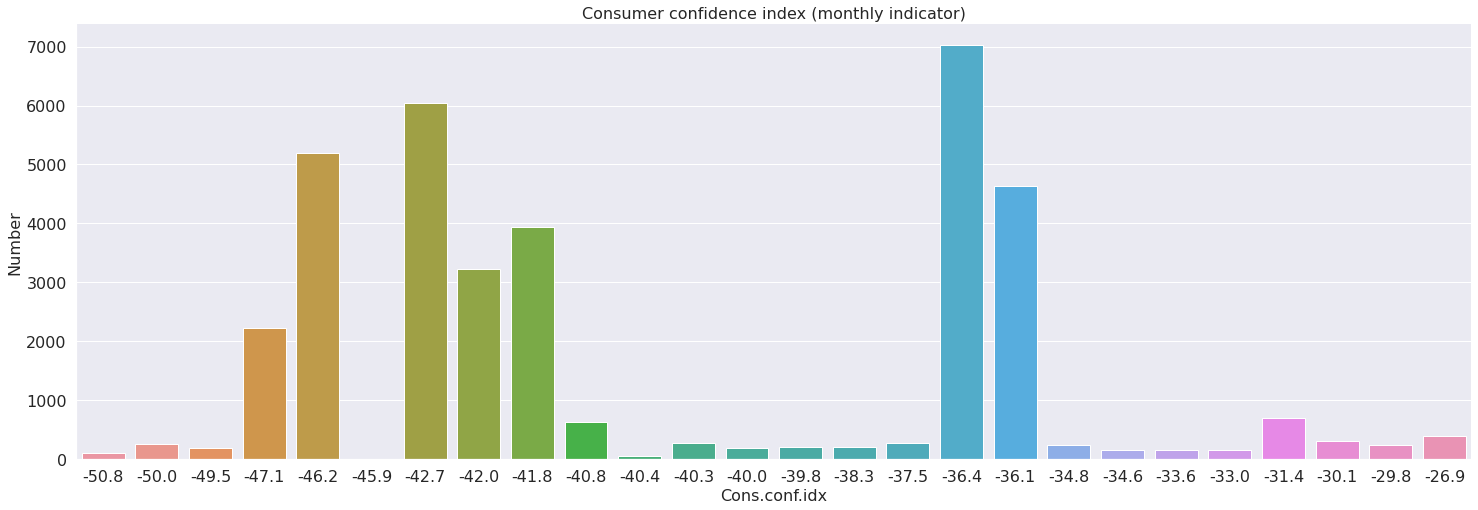

In [24]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.set(style="darkgrid")
sns.countplot(x = 'cons.conf.idx', data = train[cols_num])
ax.set_xlabel('Cons.conf.idx', fontsize=16)
ax.set_ylabel('Number', fontsize=16)
ax.set_title('Consumer confidence index (monthly indicator)', fontsize=16)
ax.tick_params(labelsize=16)
sns.despine()

Consumer confidence indicator provides an indication of future developments of households’ consumption and saving, based upon answers regarding their expected financial situation, their sentiment about the general economic situation, unemployment and capability of savings

https://data.oecd.org/leadind/consumer-confidence-index-cci.htm

We can see that the index is negative. Thus, there is a pessemistic attitude to the economic situation and agents will save more

### Categorical Features

Categorical variables are non-numeric data such as job and education. To turn these non-numerical data into variables, the simplest thing is to use a technique called one-hot encoding, which will be explained below.

The first set of categorical data we will deal with are these columns:

In [25]:
cols_cat = ['job', 'marital', 
       'education', 'default',
       'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome']

### One-Hot Encoding

To convert our categorical features to numbers, we will use a technique called one-hot encoding. In one-hot encoding, you create a new column for each unique value in that column. Then the value of the column is 1 if the sample has that unique value or 0 otherwise. For example, for the column job, we would create new columns. 

In [26]:
cols_cat = ['job', 'marital', 
       'education', 'default',
       'housing', 'loan', 'contact', 'month',
       'day_of_week', 'poutcome']
train[cols_cat]
cols_new_cat=pd.get_dummies(train[cols_cat],drop_first = False)
cols_new_cat.head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


### Graphical Representation of Categorical Features

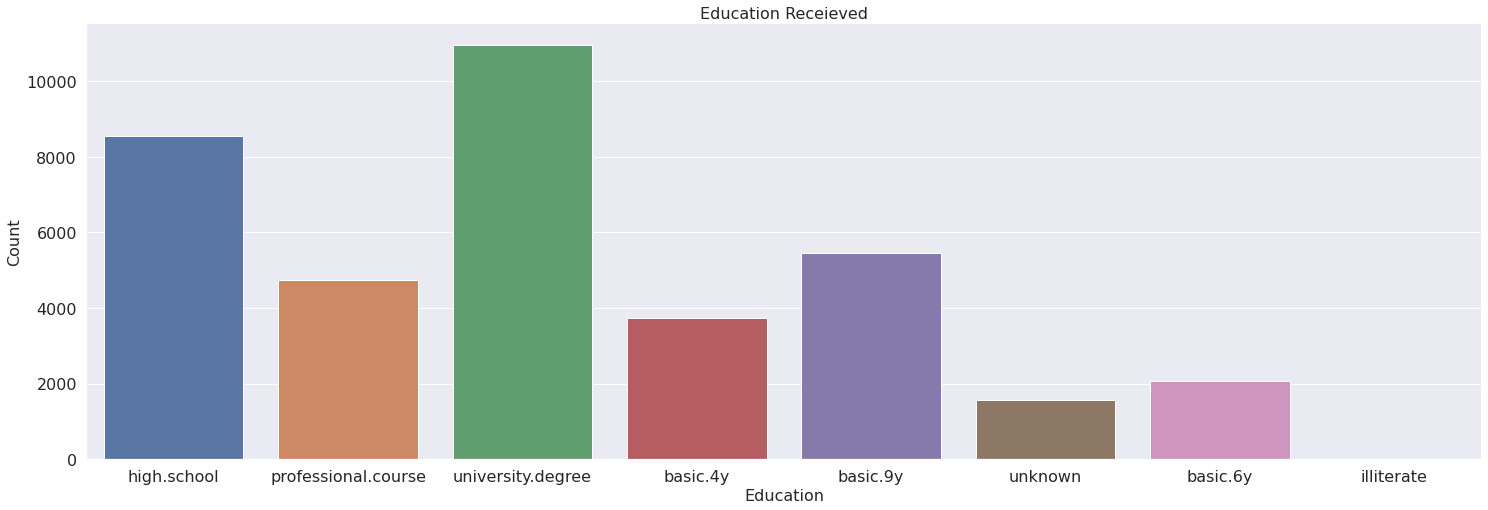

In [27]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.countplot(x = 'education', data = train[cols_cat])
sns.set(style="darkgrid")
ax.set_title('Education Receieved', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_xlabel('Education', fontsize=16)
ax.tick_params(labelsize=16)
sns.despine()

The figure shows that in most cases the clients have a university degree or high school education

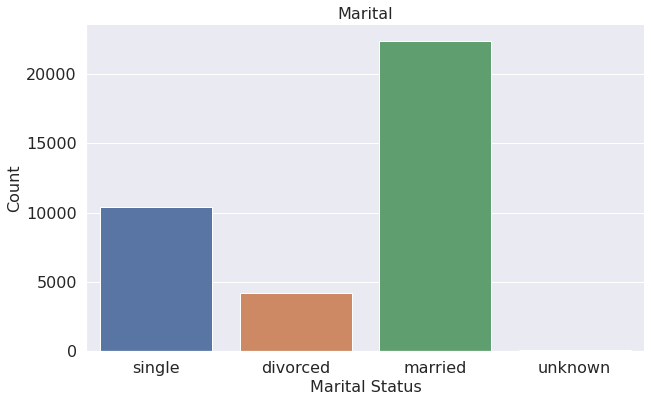

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.set(style="darkgrid")
sns.countplot(x = 'marital', data = train[cols_cat])
ax.set_xlabel('Marital Status', fontsize=16)
ax.set_ylabel('Count', fontsize=16)
ax.set_title('Marital', fontsize=16)
ax.tick_params(labelsize=16)
sns.despine()

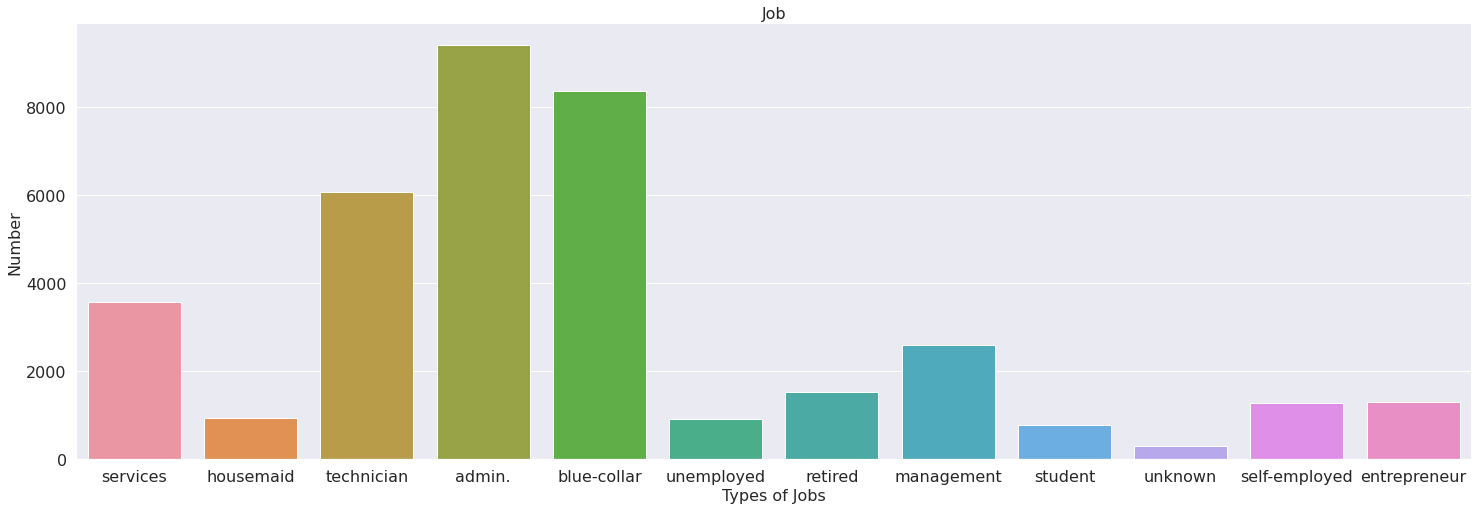

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 8)
sns.countplot(x = 'job', data = train[cols_cat])
sns.set(style="darkgrid")
ax.set_xlabel('Types of Jobs', fontsize=16)
ax.set_ylabel('Number', fontsize=16)
ax.set_title('Job', fontsize=16)
ax.tick_params(labelsize=16)
sns.despine()

Most popular jobs among clients are admin, blue-collar, tehnician, services

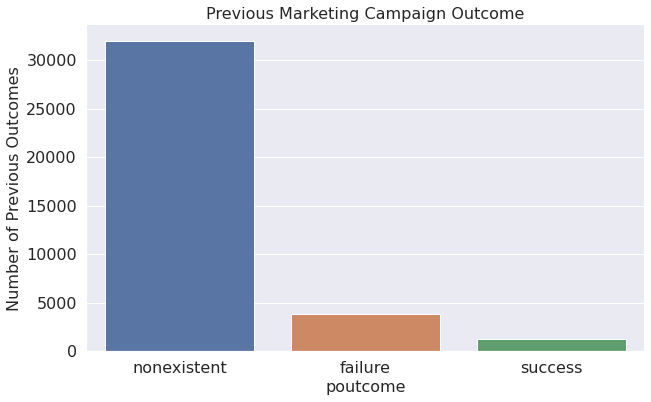

In [30]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
sns.set(style="darkgrid")
sns.countplot(x = 'poutcome', data = train[cols_cat])
ax.set_title('Previous Marketing Campaign Outcome', fontsize=16)
ax.set_ylabel('Number of Previous Outcomes', fontsize=16)
ax.set_xlabel('poutcome', fontsize=16)
ax.tick_params(labelsize=16)
sns.despine()

Seems, that  there is no experience in conducting such campaignes to sell subscriptions to a bank term deposit

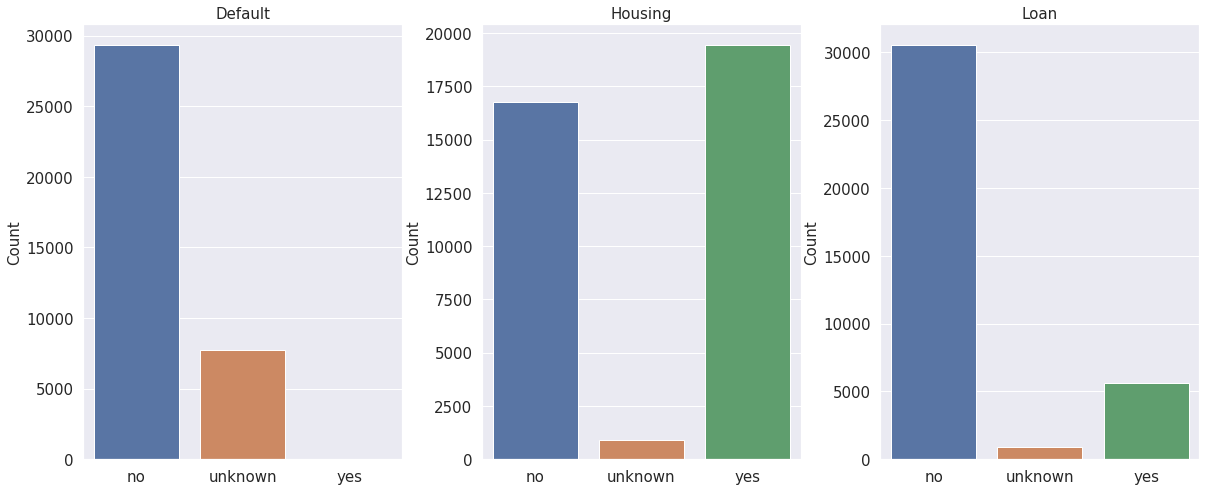

In [31]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (20,8))
sns.set(style="darkgrid")

sns.countplot(x = 'default', data = train[cols_cat], ax = ax1, order = ['no', 'unknown', 'yes'])
ax1.set_title('Default', fontsize=15)
ax1.set_xlabel('')
ax1.set_ylabel('Count', fontsize=15)
ax1.tick_params(labelsize=15)

sns.countplot(x = 'housing', data = train[cols_cat], ax = ax2, order = ['no', 'unknown', 'yes'])
ax2.set_title('Housing', fontsize=15)
ax2.set_xlabel('')
ax2.set_ylabel('Count', fontsize=15)
ax2.tick_params(labelsize=15)

sns.countplot(x = 'loan', data = train[cols_cat], ax = ax3, order = ['no', 'unknown', 'yes'])
ax3.set_title('Loan', fontsize=15)
ax3.set_xlabel('')
ax3.set_ylabel('Count', fontsize=15)
ax3.tick_params(labelsize=15)

plt.subplots_adjust(wspace=0.25)

According to this figure we can say that customers in most cases do not have credits in default. Thus, the base of clients is reliable. Also, we have almost equal share of those, who have and do not have housing loans. And most clients do not have personal loans

It is difficult to predict what percentage of customers will want to have a deposit

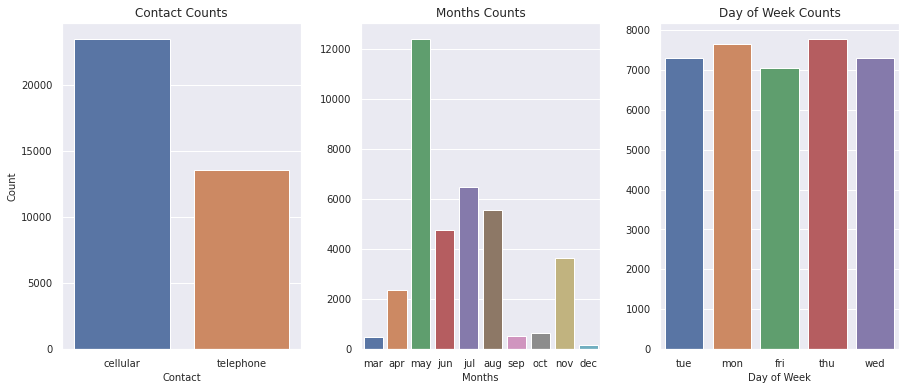

In [32]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows = 1, ncols = 3, figsize = (15,6))
sns.set(style="darkgrid")
sns.countplot(train[cols_cat]['contact'], ax = ax1)
ax1.set_xlabel('Contact', fontsize = 10)
ax1.set_ylabel('Count', fontsize = 10)
ax1.set_title('Contact Counts')
ax1.tick_params(labelsize=10)

sns.countplot(train[cols_cat]['month'], ax = ax2, order = ['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])
ax2.set_xlabel('Months', fontsize = 10)
ax2.set_ylabel('')
ax2.set_title('Months Counts')
ax2.tick_params(labelsize=10)

sns.countplot(train[cols_cat]['day_of_week'], ax = ax3)
ax3.set_xlabel('Day of Week', fontsize = 10)
ax3.set_ylabel('')
ax3.set_title('Day of Week Counts')
ax3.tick_params(labelsize=10)

plt.subplots_adjust(wspace=0.25)

These are different indicators according to the last contact of the current campaign. The large numer of calls are made by a celluar phone in May. Number of calls does not depend on the day of a week. But calls were made only on the working days

In order to add the one-hot encoding columns to the dataframe, we use the concat function. axis = 1 is used to add the columns. 

In [33]:
train_em = pd.concat([train,cols_new_cat], axis = 1)

In [34]:
cols_all_cat=list(cols_new_cat.columns)

In [35]:
train_em[cols_all_cat].head()

,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,1,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,1,0


### Summary of Features Engineering 

In [36]:
print('Total number of features:', len(cols_all_cat+cols_num))
print('Numerical Features:',len(cols_num))
print('Categorical Features:',len(cols_all_cat))

Total number of features: 62
Numerical Features: 9
Categorical Features: 53


In [37]:
tc = train[cols_num].corr()
tc

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,age,euribor3m
campaign,1.000000,0.052391,-0.080298,0.152930,0.130914,-0.012628,0.145181,0.003736,0.137269
pdays,0.052391,1.000000,-0.588111,0.271892,0.079407,-0.091451,0.373156,-0.034741,0.297622
previous,-0.080298,-0.588111,1.000000,-0.423796,-0.206879,-0.047046,-0.503292,0.025709,-0.457016
emp.var.rate,0.152930,0.271892,-0.423796,1.000000,0.775520,0.195836,0.907034,-0.005816,0.972313
cons.price.idx,0.130914,0.079407,-0.206879,0.775520,1.000000,0.059246,0.522258,-0.003946,0.688407
cons.conf.idx,-0.012628,-0.091451,-0.047046,0.195836,0.059246,1.000000,0.099731,0.128657,0.277217
nr.employed,0.145181,0.373156,-0.503292,0.907034,0.522258,0.099731,1.000000,-0.021820,0.945138
age,0.003736,-0.034741,0.025709,-0.005816,-0.003946,0.128657,-0.021820,1.000000,0.005917
euribor3m,0.137269,0.297622,-0.457016,0.972313,0.688407,0.277217,0.945138,0.005917,1.000000


<AxesSubplot:>

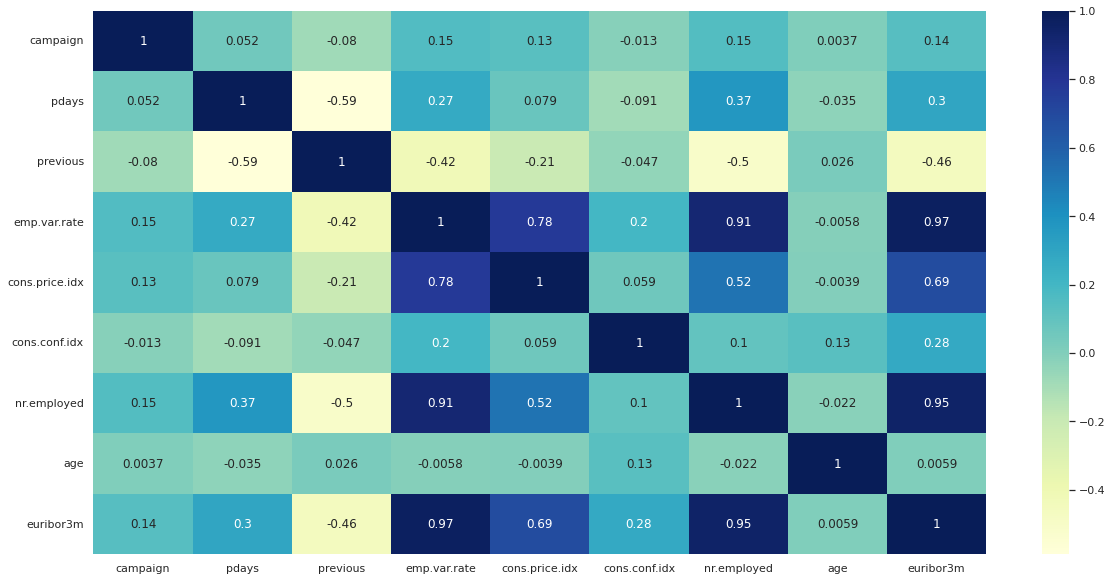

In [38]:
# Correlation matrix
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(tc, annot=True, cmap='YlGnBu')

We have a highly correlated economic indicators such as employment variation rate (emp.var.rate), consumer price index (cons.price.idx), number of employees (nr.employed) and European Interbank Offered Rate, Euribor (euribir3m)

Also, there is a low correlation between mentioned factors and number of contacts performed during this campaign (campaign)

As we have imbalanced data there are some problems with estimation, because one class of customers is dominated by the other

There are some methods that we use according to model evaluation. The basic case will be just look at confusion matrix and f1-score (as accuracy can be misleading). Also, we will modify the algorithm (use RandomDecisionClassifier instead of logistic regression). The last case is to use resample of the data to duplicate random rows of minory class (oversampling method) or remove rows of majority class (undersampling method)

## Basic version of data evaluation

There are some features of the data. The first one is that there are only 2 variables to predict. Thus, it is a case of classification problem and we can use such methods as logistic regression and trees. The second one, is that our data is imbalanced. Clients in most cases decline the purpose for deposit subcsription. In this case we will use F1-score metrics and also decision trees frequently perform well on imbalanced data

In [39]:
test = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/test_data.csv')
train = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/train_data.csv')

# Drop duration as we have problems with this parameter
# Also drop highly correlated parameters 
train = train.drop(['duration', 'emp.var.rate'], axis = 1) 
test = test.drop(['duration', 'emp.var.rate'], axis = 1)

In [40]:
cols_cat = ['job', 'marital', 'education', 'default','housing', 
            'loan', 'contact', 'poutcome', 'month', 'day_of_week']
dummies_train = pd.get_dummies(train[cols_cat])
dummies_test = pd.get_dummies(test[cols_cat])

train_prepared = pd.concat([train, dummies_train],axis=1)
train_prepared = train_prepared.drop(cols_cat, axis = 1)

test_prepared = pd.concat([test, dummies_test],axis=1)
test_prepared = test_prepared.drop(cols_cat, axis = 1)

# Data normalization
train_prepared = (train_prepared - np.min(train_prepared)) / (np.max(train_prepared) - np.min(train_prepared)).values

In [41]:
train_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37069 entries, 0 to 37068
Data columns (total 63 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            37069 non-null  float64
 1   campaign                       37069 non-null  float64
 2   pdays                          37069 non-null  float64
 3   previous                       37069 non-null  float64
 4   cons.price.idx                 37069 non-null  float64
 5   cons.conf.idx                  37069 non-null  float64
 6   euribor3m                      37069 non-null  float64
 7   nr.employed                    37069 non-null  float64
 8   y                              37069 non-null  float64
 9   id                             37069 non-null  float64
 10  job_admin.                     37069 non-null  float64
 11  job_blue-collar                37069 non-null  float64
 12  job_entrepreneur               37069 non-null 

In [42]:
test_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            4119 non-null   int64  
 1   campaign                       4119 non-null   int64  
 2   pdays                          4119 non-null   int64  
 3   previous                       4119 non-null   int64  
 4   cons.price.idx                 4119 non-null   float64
 5   cons.conf.idx                  4119 non-null   float64
 6   euribor3m                      4119 non-null   float64
 7   nr.employed                    4119 non-null   float64
 8   id                             4119 non-null   int64  
 9   job_admin.                     4119 non-null   uint8  
 10  job_blue-collar                4119 non-null   uint8  
 11  job_entrepreneur               4119 non-null   uint8  
 12  job_housemaid                  4119 non-null   u

In [43]:
X_train, X_test, y_train, y_test = train_test_split(train_prepared.drop(['y'], axis = 1), train_prepared['y'], test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)

(25948, 62)
(11121, 62)


### KNN Model

The simpliest model to classify clients according to their neighbours. In our case maybe we have lots of parameters to have a good performance of KNN

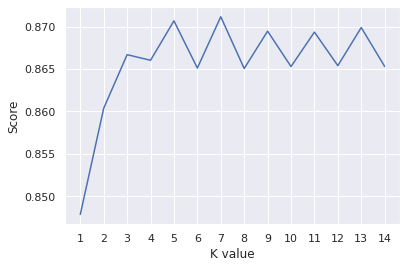

Maximum KNN Score is 87.12
Number of neighbours is 7


In [44]:
scores = []
for i in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors = i)
    knn.fit(X_train, y_train)
    result = knn.predict(X_test)
    scores.append(f1_score(y_test, result, average ='weighted'))
    
plt.plot(range(1, 15), scores)
plt.xticks(np.arange(1, 15, 1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

mer = max(scores)*100
print("Maximum KNN Score is %.2f" % mer)
print("Number of neighbours is", np.argmax(scores)+1)

Alternative F1-score (not weighted) 30.46


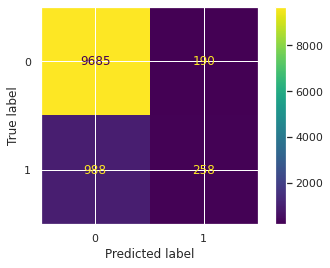

In [45]:
# Plot the confusion matrix
knn = KNeighborsClassifier(n_neighbors = 7)
knn.fit(X_train, y_train)
result_knn = knn.predict(X_test)

print("Alternative F1-score (not weighted) %.2f" %(f1_score(y_test, result_knn)*100))
cm_knn = confusion_matrix(y_test,result_knn)
cm_display = ConfusionMatrixDisplay(cm_knn).plot()

KNN is not the best way to model the imbalanced data. However, we have not low f1-score on our train dataset

Also, here we can see that in most cases our model give wrong answers for true values (high FP). That is better than have high FT. We predict that a client does not have the subscription, but it is not true. And this situation is not as awful as to predict that a client has a subscription, but it is not true. The last means we lose the client

### Logistic Regression

It is a basic method to estimate data that has discrete values

In [46]:
LR = LogisticRegression(solver='liblinear')
LR.fit(X_train, y_train)
result_LR = LR.predict(X_test)
score_LR_weight = f1_score(y_test, result_LR, average ='weighted')
print('F1-score of the model Logistic Regression is %.2f' %(score_LR_weight*100))

F1-score of the model Logistic Regression is 87.73


Seems, that we have high F1-score. But it is possible only if we use the *'weighted'* option for F1-score. It allows to take into account imbalance of classes 

In [47]:
score = f1_score(y_test, result_LR)
print('F1-score of the model Logistic Regression is %.2f' %(score*100))

F1-score of the model Logistic Regression is 33.27


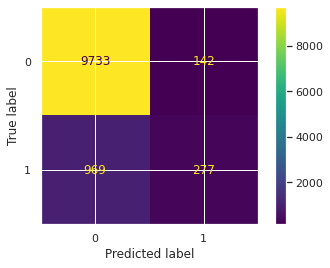

In [48]:
# Plot the confusion matrix
cm_LR = confusion_matrix(y_test,result_LR)
cm_display = ConfusionMatrixDisplay(cm_LR).plot()

Logistic Regression is better than KNN. We have less false predicions

In [49]:
# Try to use some polinomials for our model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

LR_norm = make_pipeline(
    PolynomialFeatures(2),
    LogisticRegression(solver='liblinear')
)
LR_norm.fit(X_train, y_train)
result_LR_norm = LR_norm.predict(X_test)
score_norm = f1_score(y_test, result_LR_norm)
print('F1-score of the model Logistic Regression with normalized data is %.2f' %(score_norm*100))

F1-score of the model Logistic Regression with normalized data is 35.77


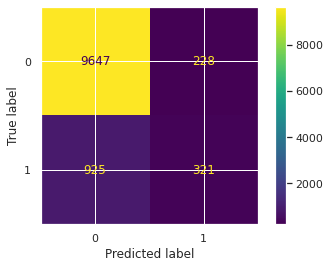

In [50]:
cm_LR = confusion_matrix(y_test, result_LR_norm)
cm_display = ConfusionMatrixDisplay(cm_LR).plot()

Even if we try to add polinomials, we do not get much better results

### Decision Tree
Allows to predict data according to simple if-else conditions. However, it can lead to high variance problem, that leads to overfittinf

In [51]:
DT = DecisionTreeClassifier(criterion='entropy')

params = {'min_samples_leaf': [2, 3, 4],
          'max_depth': [1, 2, 3, 5, 7, 9, 10, 15, 20]}

tree_search = GridSearchCV(DT, 
                           params, 
                           cv=5 , 
                           return_train_score=False, 
                           scoring='f1',
                           n_jobs=4)
tree_search.fit(X_train, y_train)
tree = tree_search.best_estimator_
print('Best parameters found by grid search:', tree_search.best_params_, '\n')

Best parameters found by grid search: {'max_depth': 5, 'min_samples_leaf': 2} 



In [52]:
result_tree = tree_search.predict(X_test)
score_tree_weight = f1_score(y_test, result_tree, average ='weighted')
print('F1-score of the Decision Tree is %.2f' %(score_tree_weight*100))

F1-score of the Decision Tree is 87.98


In [53]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11121 entries, 13504 to 22950
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            11121 non-null  float64
 1   campaign                       11121 non-null  float64
 2   pdays                          11121 non-null  float64
 3   previous                       11121 non-null  float64
 4   cons.price.idx                 11121 non-null  float64
 5   cons.conf.idx                  11121 non-null  float64
 6   euribor3m                      11121 non-null  float64
 7   nr.employed                    11121 non-null  float64
 8   id                             11121 non-null  float64
 9   job_admin.                     11121 non-null  float64
 10  job_blue-collar                11121 non-null  float64
 11  job_entrepreneur               11121 non-null  float64
 12  job_housemaid                  11121 non-n

In [54]:
score_tree = f1_score(y_test, result_tree)
print('F1-score of the Decision Tree is %.2f' %(score_tree*100))

F1-score of the Decision Tree is 36.39


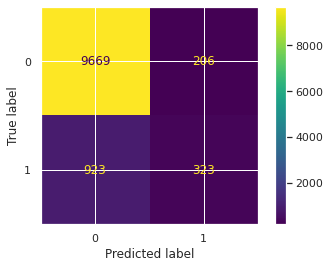

In [55]:
cm_tree = confusion_matrix(y_test,result_tree)
cm_display = ConfusionMatrixDisplay(cm_tree).plot()

We have better results than for previous models



### Random Forest
It allows to predict according to estimate the number of trees and make an aggregate prediction using predictions from trees. Also, as Decision Trees this method allows to offset the problem of imbalanced data

In [56]:
params = {
    'n_estimators': range(1, 60, 5),
    'max_depth': range(2, 50, 5),
    }

Random_Forest = RandomForestClassifier(n_jobs=4, criterion = 'entropy', 
                                       random_state=42)
grid_search = GridSearchCV(Random_Forest, params, cv = 5, scoring='f1', n_jobs=4)
grid_search.fit(X_train, y_train)

grid = grid_search.best_estimator_
print('Best parameters found by randomised search:', grid_search.best_params_, '\n')

Best parameters found by randomised search: {'max_depth': 37, 'n_estimators': 11} 



In [57]:
result_RF = grid_search.predict(X_test)
score_RF_weight = f1_score(y_test, result_RF, average ='weighted')
print('F1-score of the Random Forest is %.2f' %(score_RF_weight*100))

F1-score of the Random Forest is 87.62


In [58]:
score_RF = f1_score(y_test, result_RF)
print('F1-score of the Random Forest is %.2f' %(score_RF*100))

F1-score of the Random Forest is 36.67


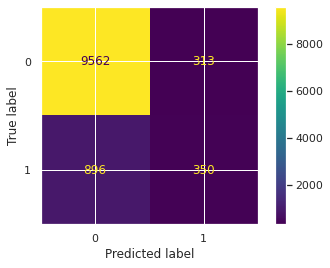

In [59]:
cm_RF = confusion_matrix(y_test,result_RF)
cm_display = ConfusionMatrixDisplay(cm_RF).plot()

### Gradient Boosting

In [60]:
gbc = GradientBoostingClassifier(random_state=42)

random_grid_gbc = {'n_estimators': range(5, 60, 10),
                   'max_depth': range(1, 20, 5)}

# create the randomized search cross-validation
gbc_random = GridSearchCV(gbc,
                          random_grid_gbc, 
                          cv = 2, 
                          scoring='f1',
                          n_jobs=4,
                          verbose = 0)

gbc_random.fit(X_train, y_train)
gbc = gbc_random.best_params_

In [61]:
gbc_random.best_params_

{'max_depth': 6, 'n_estimators': 55}

In [62]:
result_gbc = gbc_random.predict(X_test)
score_gbc_weight = f1_score(y_test, result_gbc, average ='weighted')
print('F1-score of the Gradient Boosting is %.2f' %(score_gbc_weight*100))

F1-score of the Gradient Boosting is 87.93


In [63]:
score_gbc = f1_score(y_test, result_gbc)
print('F1-score of the Gradient Boosting is %.2f' %(score_gbc*100))

F1-score of the Gradient Boosting is 35.77


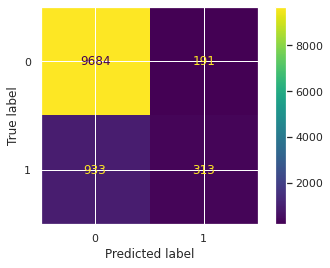

In [64]:
cm_gbc = confusion_matrix(y_test,result_gbc)
cm_display = ConfusionMatrixDisplay(cm_gbc).plot()

According to provided analysis models are not good enough (according to F1-score not weighted). So, we need to try other methods and try to rebalance our data 

However, for this part we also can make some predictions

### Results for this part

In [65]:
df_results = pd.DataFrame({'models':['KNN', 'Logit', 'Decision Tree', 'Random Forest', 'Gradient Boosting'],
                          'f1_weighted':[mer/100,score_LR_weight,
                                 score_tree_weight,score_RF_weight,
                                 score_gbc_weight],
                          })
df_results

,models,f1_weighted
0,KNN,0.871182
1,Logit,0.877296
2,Decision Tree,0.879754
3,Random Forest,0.876245
4,Gradient Boosting,0.879333


## Alterantive ways to resample dataset

Unfortunately, here we have the bad proportion of FP and FN predictions. The more clients we predict as already have subscriptions and not call them (big FP). But this is a bad way, we miss potential clients. It is better if we call by mistake clients (big FN), who already have a subscription. They just decline the proposal

You can see the results under the same title at the end of the notebook

## Predictions

According to models above we can make predictions. We are oriented by F1-score and also will take models from the first part of this section, before resampling. Let's make predictions using Decision Tree as it has the highest F1-score, provide not as long estimations as Random Forest and more intuitive than Gradient Boosting

In [66]:
test_prepared.insert(34, "default_yes", 0, True)
test_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 62 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            4119 non-null   int64  
 1   campaign                       4119 non-null   int64  
 2   pdays                          4119 non-null   int64  
 3   previous                       4119 non-null   int64  
 4   cons.price.idx                 4119 non-null   float64
 5   cons.conf.idx                  4119 non-null   float64
 6   euribor3m                      4119 non-null   float64
 7   nr.employed                    4119 non-null   float64
 8   id                             4119 non-null   int64  
 9   job_admin.                     4119 non-null   uint8  
 10  job_blue-collar                4119 non-null   uint8  
 11  job_entrepreneur               4119 non-null   uint8  
 12  job_housemaid                  4119 non-null   u

In [67]:
y_test_preds = tree_search.predict(test_prepared).astype(int)

In [68]:
y_test_preds

array([0, 0, 0, ..., 1, 1, 1])

In [69]:
submissions = pd.DataFrame()

In [70]:
submissions['id'] = test['id'].astype('string')
submissions['y'] = y_test_preds

In [71]:
submissions = submissions.astype('string')

In [72]:
submissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4119 non-null   string
 1   y       4119 non-null   string
dtypes: string(2)
memory usage: 64.5 KB


In [73]:
submissions.to_csv('submission1_1.csv', sep = ',', index = False)

## Building Training & Validation Samples

So far we have explored our data and created features from the categorical data. It is now time for us to split our data. The idea behind splitting the data is so that you can measure how well your model would do on unseen data. We split the train data into two parts:

Training samples: these are samples from the data set used to train the model. It can be 80% of the data.

Validation samples: these are samples used to validate or make decisions from the model. It can be 20% of the data.

Test samples: We already have a data for this

In this project, we will split into 80% train and 20% validation.

Let's shuffle the samples using sample in case there was some order (e.g. all positive samples on top). 

*n* - the number of samples

*random_state* - just specified so the project is reproducable.

Shuffle the samples

In [74]:
#shuffle the samples
train = train_em.sample(n = len(train), random_state = 42)
train = train_em.reset_index(drop = True)

20% of the validation sample:

In [75]:
df_valid=train.sample(frac=0.20,random_state=42)
print('Split size: %.3f'%(len(df_valid)/len(train)))

Split size: 0.200


In [76]:
# use the rest of the data as training data
df_train_all=train.drop(df_valid.index)

In [77]:
# check the prevalence of each category (y = 0/1)
print('Valid prevalence(n = %d):%.3f'%(len(df_valid),len(df_valid[df_valid.y == 1])/(len(df_valid[df_valid.y == 1])+len(df_valid[df_valid.y == 0]))))
print('Train all prevalence(n = %d):%.3f'%(len(df_train_all),len(df_valid[df_valid.y == 1])/(len(df_valid[df_valid.y == 1])+len(df_valid[df_valid.y == 0]))))

Valid prevalence(n = 7414):0.111
Train all prevalence(n = 29655):0.111


In [78]:
# split the training data into positive and negative
rows_pos = df_train_all.y == 1
df_train_pos = df_train_all.loc[rows_pos]
df_train_neg = df_train_all.loc[~rows_pos]

# merge the balanced data
df_train = pd.concat([df_train_pos, df_train_neg.sample(n = len(df_train_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_train = df_train.sample(n = len(df_train), random_state = 42).reset_index(drop = True)

print('Train balanced prevalence(n = %d):%.3f'%(len(df_train), len(df_train[df_train.y == 1])/(len(df_train[df_train.y == 1])+len(df_train[df_train.y == 0]))))

Train balanced prevalence(n = 6708):0.500


In [79]:
# split the validation into positive and negative
rows_pos = df_valid.y == 1
df_valid_pos = df_valid.loc[rows_pos]
df_valid_neg = df_valid.loc[~rows_pos]

# merge the balanced data
df_valid = pd.concat([df_valid_pos, df_valid_neg.sample(n = len(df_valid_pos), random_state = 42)],axis = 0)

# shuffle the order of training samples 
df_valid = df_valid.sample(n = len(df_valid), random_state = 42).reset_index(drop = True)

print('Valid balanced prevalence(n = %d):%.3f'%(len(df_valid), len(df_valid[df_valid.y == 1])/(len(df_valid[df_valid.y == 1])+len(df_valid[df_valid.y == 0]))))

Valid balanced prevalence(n = 1648):0.500


In [80]:
df_train_all.to_csv('df_train_all.csv',index=False)
df_train.to_csv('df_train.csv',index=False)
df_valid.to_csv('df_valid.csv',index=False)

In [81]:
cols_input = cols_num + cols_all_cat

Saving cols_input too with a package called pickle

In [82]:
pickle.dump(cols_input, open('cols_input.sav', 'wb'))

Any missing values were filled with the mean value

In [83]:
def fill_my_missing(df, df_mean, col2use):
    # This function fills the missing values

    # check the columns are present
    for c in col2use:
        assert c in df.columns, c + ' not in df'
        assert c in df_mean.col.values, c+ 'not in df_mean'
    
    # replace the mean 
    for c in col2use:
        mean_value = df_mean.loc[df_mean.col == c,'mean_val'].values[0]
        df[c] = df[c].fillna(mean_value)
    return df

The mean value from the training data:

In [84]:
df_mean = df_train_all[cols_input].mean(axis = 0)
# save the means
df_mean.to_csv('df_mean.csv',index=True)

Load the means

In [85]:
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
df_mean_in.head()

,col,mean_val
0,NaN,0.000000
1,campaign,2.575923
2,pdays,961.967560
3,previous,0.174068
4,emp.var.rate,0.082586


In [86]:
df_train_all = fill_my_missing(df_train_all, df_mean_in, cols_input)
df_train = fill_my_missing(df_train, df_mean_in, cols_input)
df_valid = fill_my_missing(df_valid, df_mean_in, cols_input)

In [87]:
# create the X and y matrices
X_train = df_train[cols_input].values
X_train_all = df_train_all[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train['y'].values
y_valid = df_valid['y'].values

print('Training All shapes:',X_train_all.shape)
print('Training shapes:',X_train.shape, y_train.shape)
print('Validation shapes:',X_valid.shape, y_valid.shape)

Training All shapes: (29655, 62)
Training shapes: (6708, 62) (6708,)
Validation shapes: (1648, 62) (1648,)


Created a scalar, saved it, and scaled the X matrices

In [88]:
scaler = StandardScaler()
scaler.fit(X_train_all)

StandardScaler()

In [89]:
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [90]:
# load it back
scaler = pickle.load(open(scalerfile, 'rb'))

In [91]:
# transform our data matrices
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

## Model Selection 

This section allows us to test various machine learning algorithm to see how our independent variables accurately predict our dependent y output variable. We will then select the best model based on performance on the validation set.
We will utilize the following functions to evaluate the performance of the model.

In [92]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)
    f1 = 2 * (precision * recall) / (precision + recall)
   
    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print('prevalence:%.3f'%calc_prevalence(y_actual))
    print('f1:%.3f'%f1)
    print(' ')
    return auc, accuracy, recall, precision, specificity, f1

Since we balanced our training data, let's set our threshold at 0.5 to label a predicted sample as positive. 

In [93]:
thresh = 0.5

In this section, we will first compare the performance of the following 7 machine learning models using default hyperparameters:

- K-nearest neighbors

- Logistic regression

- Stochastic gradient descent

- Naive Bayes

- Decision tree

- Random forest

- Gradient boosting classifier


### K nearest neighbors (KNN)

K Nearest Neighbors looks at the k closest datapoints and probability sample that has positive labels. It is easy to implement, and you don't need an assumption for the data structure. KNN is also good for multivariate analysis.

Training and evaluating KNN performance:

In [94]:
knn=KNeighborsClassifier(n_neighbors = 100)
knn.fit(X_train_tf, y_train)

KNeighborsClassifier(n_neighbors=100)

In [95]:
y_train_preds = knn.predict_proba(X_train_tf)[:,1]
y_valid_preds = knn.predict_proba(X_valid_tf)[:,1]

print('KNN')
print('Training:')
knn_train_auc, knn_train_accuracy, knn_train_recall, \
    knn_train_precision, knn_train_specificity, knn_train_f1 = print_report(y_train,y_train_preds, thresh)
print('Validation:')
knn_valid_auc, knn_valid_accuracy, knn_valid_recall, \
    knn_valid_precision, knn_valid_specificity, knn_valid_f1 = print_report(y_valid,y_valid_preds, thresh)

KNN
Training:
AUC:0.793
accuracy:0.737
recall:0.612
precision:0.816
specificity:0.854
prevalence:0.500
f1:0.699
 
Validation:
AUC:0.774
accuracy:0.727
recall:0.596
precision:0.808
specificity:0.852
prevalence:0.500
f1:0.686
 


For the training set, I was able to get an AUC of 79.4% which catches 62.5% (recall) of potential customers using a threshold of 0.5 which is good. Let's take a look at the remaining algorithms below!

### Logistic Regression

Logsitic regression uses a line (Sigmoid function) in the form of an "S" to predict if the dependent variable is true or false based on the independent variables. The "S-shaped" curve (on the line graph) will show the probability of the dependent variable occuring based on where the points of the independent variables lands on the curve. In this case, the output (y) is predicted by the numerical and categorical variables defined as "x" such as age, education and so on. Logistic regresssion is best used for classifying samples.

Training and evaluating the logistic regression performance:

In [96]:
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [97]:
y_train_preds = lr.predict_proba(X_train_tf)[:,1]
y_valid_preds = lr.predict_proba(X_valid_tf)[:,1]

print('Logistic Regression')
print('Training:')
lr_train_auc, lr_train_accuracy, lr_train_recall, \
    lr_train_precision, lr_train_specificity, lr_train_f1= print_report(y_train,y_train_preds, thresh)
print('Validation:')
lr_valid_auc, lr_valid_accuracy, lr_valid_recall, \
    lr_valid_precision, lr_valid_specificity, lr_valid_f1= print_report(y_valid,y_valid_preds, thresh)

Logistic Regression
Training:
AUC:0.798
accuracy:0.746
recall:0.640
precision:0.812
specificity:0.852
prevalence:0.500
f1:0.716
 
Validation:
AUC:0.780
accuracy:0.740
recall:0.625
precision:0.811
specificity:0.854
prevalence:0.500
f1:0.706
 


### Stochastic Gradient Descent

Stochastic Gradient Descent analyzes various sections of the data instead of the data as a whole and predicts the output using the independent variables. Stochastic Gradient Descent is faster than logistic regression in the sense that it doesn't run the whole dataset but instead looks at different parts of the dataset.

Training and evaluating Stochastic Gradient Descent model performance:

In [98]:
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, loss='log', random_state=42)

In [99]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

print('Stochastic Gradient Descent')
print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity, sgdc_train_f1 =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity, sgdc_valid_f1 = print_report(y_valid,y_valid_preds, thresh)

Stochastic Gradient Descent
Training:
AUC:0.794
accuracy:0.741
recall:0.654
precision:0.793
specificity:0.829
prevalence:0.500
f1:0.717
 
Validation:
AUC:0.778
accuracy:0.732
recall:0.635
precision:0.789
specificity:0.830
prevalence:0.500
f1:0.703
 


### Naive Bayes

Naive Bayes assumes that all variables in the dataset are independent of each other. Meaning that there are no dependent variables or output. This algorithm uses Bayes rule which calculated the probability of an event related to previous knowledge of the variables concerning the event. This won't really work in this case since we have an output of the bank customers who will get a bank deposit. This process is better for tasks such as image processing.

Training and evaluating Naive Bayes model performance:

In [100]:
nb = GaussianNB()
nb.fit(X_train_tf, y_train)

GaussianNB()

In [101]:
y_train_preds = nb.predict_proba(X_train_tf)[:,1]
y_valid_preds = nb.predict_proba(X_valid_tf)[:,1]

print('Naive Bayes')
print('Training:')
nb_train_auc, nb_train_accuracy, nb_train_recall, nb_train_precision, nb_train_specificity, nb_train_f1 =print_report(y_train,y_train_preds, thresh)
print('Validation:')
nb_valid_auc, nb_valid_accuracy, nb_valid_recall, nb_valid_precision, nb_valid_specificity, nb_valid_f1 = print_report(y_valid,y_valid_preds, thresh)

Naive Bayes
Training:
AUC:0.770
accuracy:0.674
recall:0.409
precision:0.869
specificity:0.938
prevalence:0.500
f1:0.557
 
Validation:
AUC:0.758
accuracy:0.660
recall:0.371
precision:0.877
specificity:0.948
prevalence:0.500
f1:0.522
 


### Decision Tree Classifier

Decision trees works through the data to decide if one action occurs, what will then be the result of a "yes" and a "no". It works each data making the decision of which path to take based on the answer. Because of this decision making process, this algorithm has no assumptions about the structure of the data, but instead decides on the path to take through each decision the algorithm performs.

Training and evaluating Decision Tree model performance:

In [102]:
tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [103]:
y_train_preds = tree.predict_proba(X_train_tf)[:,1]
y_valid_preds = tree.predict_proba(X_valid_tf)[:,1]

print('Decision Tree')
print('Training:')
tree_train_auc, tree_train_accuracy, tree_train_recall, tree_train_precision, tree_train_specificity, tree_train_f1 =print_report(y_train,y_train_preds, thresh)
print('Validation:')
tree_valid_auc, tree_valid_accuracy, tree_valid_recall, tree_valid_precision, tree_valid_specificity, tree_valid_f1 = print_report(y_valid,y_valid_preds, thresh)

Decision Tree
Training:
AUC:0.869
accuracy:0.796
recall:0.683
precision:0.883
specificity:0.904
prevalence:0.500
f1:0.770
 
Validation:
AUC:0.746
accuracy:0.708
recall:0.575
precision:0.782
specificity:0.837
prevalence:0.500
f1:0.663
 


### Random Forest

Random forest works like a decision tree algorithm but it performs various decision tree analysis on the dataset as a whole. That is, it is the bigger version of the decision tree; a forest is bigger than a tree, you can think of it that way. Random forest takes random samples of trees and it works faster than the decision tree algorithm. 

Training and evaluating Random Forest model performance:

In [104]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [105]:
y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

print('Random Forest')
print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity, rf_train_f1 =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity, rf_valid_f1 = print_report(y_valid,y_valid_preds, thresh)

Random Forest
Training:
AUC:0.814
accuracy:0.752
recall:0.647
precision:0.819
specificity:0.857
prevalence:0.500
f1:0.723
 
Validation:
AUC:0.785
accuracy:0.732
recall:0.620
precision:0.800
specificity:0.845
prevalence:0.500
f1:0.699
 


### Gradient Boosting Classifier

Boosting is a technique that builds a new decision tree algorithm that focuses on the errors on the dataset to fix them. This learns the whole model in other to fix it and improve the prediction of the model. Aside from being related to decision trees, it also relates to gradient descent algorithm as the name signifies. Gradient boosting analyzes different parts of the dataset and builds trees that focuses and corrects those errors. The XGBoost library is also the determining factor in winning a lot of Kaggle data science competitions.

Training and evaluating Gradient Boosting model performance:

In [106]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [107]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

print('Gradient Boosting Classifier')
print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity, gbc_train_f1 = print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity, gbc_valid_f1 = print_report(y_valid,y_valid_preds, thresh)

Gradient Boosting Classifier
Training:
AUC:0.901
accuracy:0.819
recall:0.751
precision:0.869
specificity:0.887
prevalence:0.500
f1:0.806
 
Validation:
AUC:0.752
accuracy:0.707
recall:0.638
precision:0.740
specificity:0.775
prevalence:0.500
f1:0.685
 


### Analyze results baseline models

Let's make a dataframe with these results and plot the outcomes using a package called seaborn - making a dataframe with the results of all the baseline models and plot the outcomes. In this project, we will utilize the F1-score to evaluate the best model. This is a good data science performance metric for picking the best model since it captures the trade off between precision and recall.

In [108]:
df_results = pd.DataFrame({'classifier':['KNN','KNN','LR','LR','SGD','SGD','NB','NB','DT','DT','RF','RF','GB','GB'],
                           'data_set':['train','valid']*7,
                          'auc':[knn_train_auc, knn_valid_auc,lr_train_auc,lr_valid_auc,sgdc_train_auc,sgdc_valid_auc,nb_train_auc,nb_valid_auc,tree_train_auc,tree_valid_auc,rf_train_auc,rf_valid_auc,gbc_train_auc,gbc_valid_auc,],
                          'accuracy':[knn_train_accuracy, knn_valid_accuracy,lr_train_accuracy,lr_valid_accuracy,sgdc_train_accuracy,sgdc_valid_accuracy,nb_train_accuracy,nb_valid_accuracy,tree_train_accuracy,tree_valid_accuracy,rf_train_accuracy,rf_valid_accuracy,gbc_train_accuracy,gbc_valid_accuracy,],
                          'recall':[knn_train_recall, knn_valid_recall,lr_train_recall,lr_valid_recall,sgdc_train_recall,sgdc_valid_recall,nb_train_recall,nb_valid_recall,tree_train_recall,tree_valid_recall,rf_train_recall,rf_valid_recall,gbc_train_recall,gbc_valid_recall,],
                          'precision':[knn_train_precision, knn_valid_precision,lr_train_precision,lr_valid_precision,sgdc_train_precision,sgdc_valid_precision,nb_train_precision,nb_valid_precision,tree_train_precision,tree_valid_precision,rf_train_precision,rf_valid_precision,gbc_train_precision,gbc_valid_precision,],
                          'specificity':[knn_train_specificity, knn_valid_specificity,lr_train_specificity,lr_valid_specificity,sgdc_train_specificity,sgdc_valid_specificity,nb_train_specificity,nb_valid_specificity,tree_train_specificity,tree_valid_specificity,rf_train_specificity,rf_valid_specificity,gbc_train_specificity,gbc_valid_specificity,],
                          'f1':[knn_train_f1, knn_valid_f1,lr_train_f1,lr_valid_f1,sgdc_train_f1,sgdc_valid_f1,nb_train_f1,nb_valid_f1,tree_train_f1,tree_valid_f1,rf_train_f1,rf_valid_f1,gbc_train_f1,gbc_valid_f1,],
                          })
df_results

,classifier,data_set,auc,accuracy,recall,precision,specificity,f1
0,KNN,train,0.793475,0.736881,0.612105,0.815654,0.853608,0.699370
1,KNN,valid,0.773641,0.726942,0.595874,0.807566,0.851942,0.685754
2,LR,train,0.798457,0.746124,0.640131,0.812334,0.852117,0.716025
3,LR,valid,0.779511,0.739684,0.625000,0.811024,0.854369,0.705963
4,SGD,train,0.793735,0.741354,0.653846,0.792555,0.828861,0.716550
5,SGD,valid,0.778205,0.732403,0.634709,0.788839,0.830097,0.703430
6,NB,train,0.769906,0.673822,0.409362,0.868987,0.938283,0.556546
7,NB,valid,0.757807,0.659587,0.371359,0.876791,0.947816,0.521739
8,DT,train,0.869300,0.796213,0.683065,0.882852,0.904293,0.770213
9,DT,valid,0.746431,0.707524,0.575243,0.782178,0.837379,0.662937


Here we choose three best models (according to F1-score):

- SGD (stochastic gradient descent)
- RF (random forest)
- GB (gradient boosting)

Later we will try to find best parameters for them and improve the score

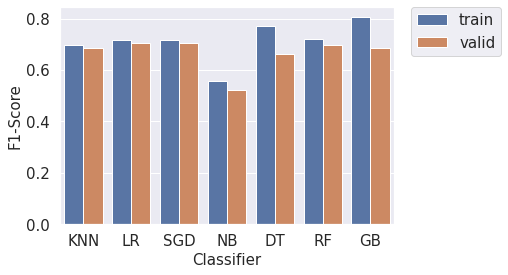

In [109]:
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="f1", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('F1-Score', fontsize = 15)
ax.tick_params(labelsize=15)

# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)
plt.show()

## Learning Curves

We can diagnose how our models are doing by plotting a learning curve. In this section, we will make use of the learning curve code from scikit-learn’s website with a small change of plotting the F1-score instead of accuracy. ??? has the best AUC score (0.8) for the validation model and the learning curve for the model will be displayed below.

In [110]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("F1-score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring = 'f1')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="b")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="b",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

The Stochastic Gradient Descent model with max_depth = 20, resulting in high variance

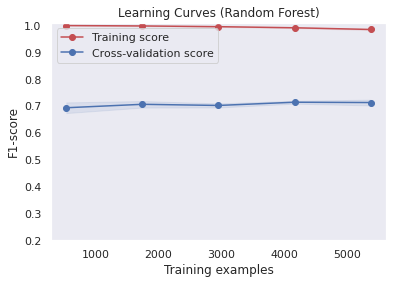

In [111]:
title = "Learning Curves (Random Forest)"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
estimator = RandomForestClassifier(max_depth = 20, random_state = 42)
plot_learning_curve(estimator, title, X_train_tf, y_train, ylim=(0.2, 1.01), cv=cv, n_jobs=4)

plt.show()

## Variance and Bias

In the case of random forest, we can see the model has high variance because the training and cross-validation scores show data points which are very spread out from one another. High variance would cause an algorithm to model the noise in the training set (overfitting).

Depending on the learning curve, there are a few strategies we can employ to improve the models

High Variance:
- Add more samples
- Add regularization
- Reduce number of features
- Decrease model complexity
- Add better features
- Change model architecture

High Bias:
- Add new features
- Increase model complexity
- Reduce regularization
- Change model architecture

## Feature Importance

This section focuses on the importance of the different features generated and in the dataframe. Depending on the importance score of some features, we can focus on higher importance scores to see if the F1-score (performance) of the model will improve.

### Logistic Regression

In [112]:
lr=LogisticRegression(random_state = 42)
lr.fit(X_train_tf, y_train)

LogisticRegression(random_state=42)

In [113]:
feature_importances = pd.DataFrame(lr.coef_[0],
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)

In [114]:
feature_importances

,importance
cons.price.idx,1.082051
euribor3m,0.579558
month_aug,0.254351
nr.employed,0.224582
month_mar,0.172212
...,...
month_jun,-0.125648
month_may,-0.147644
contact_telephone,-0.171444
pdays,-0.212272


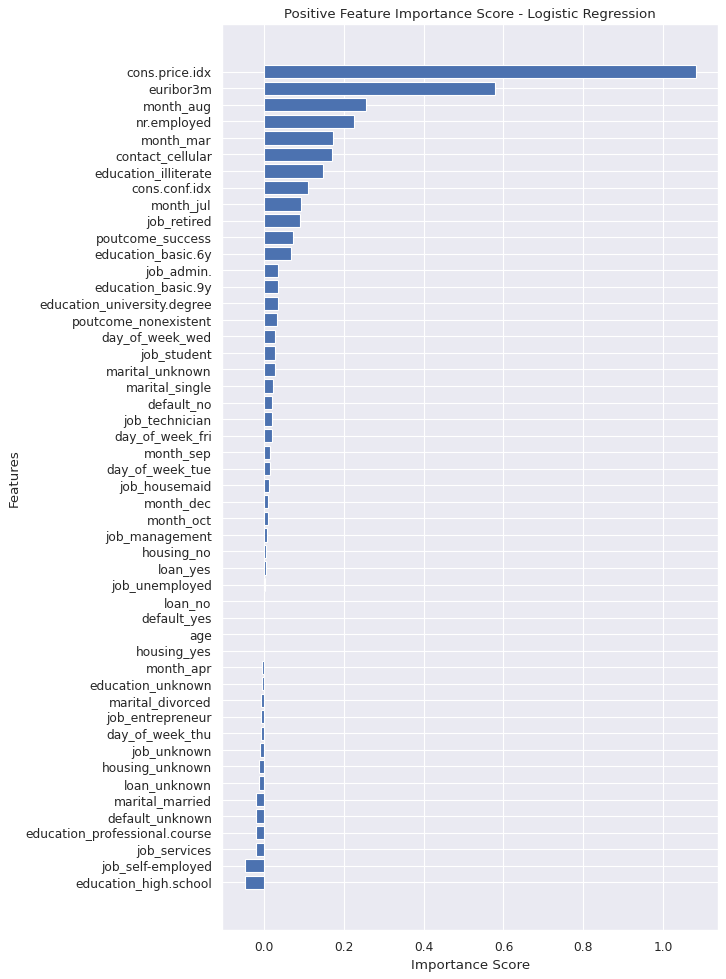

In [115]:
num = np.min([50, len(cols_input)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

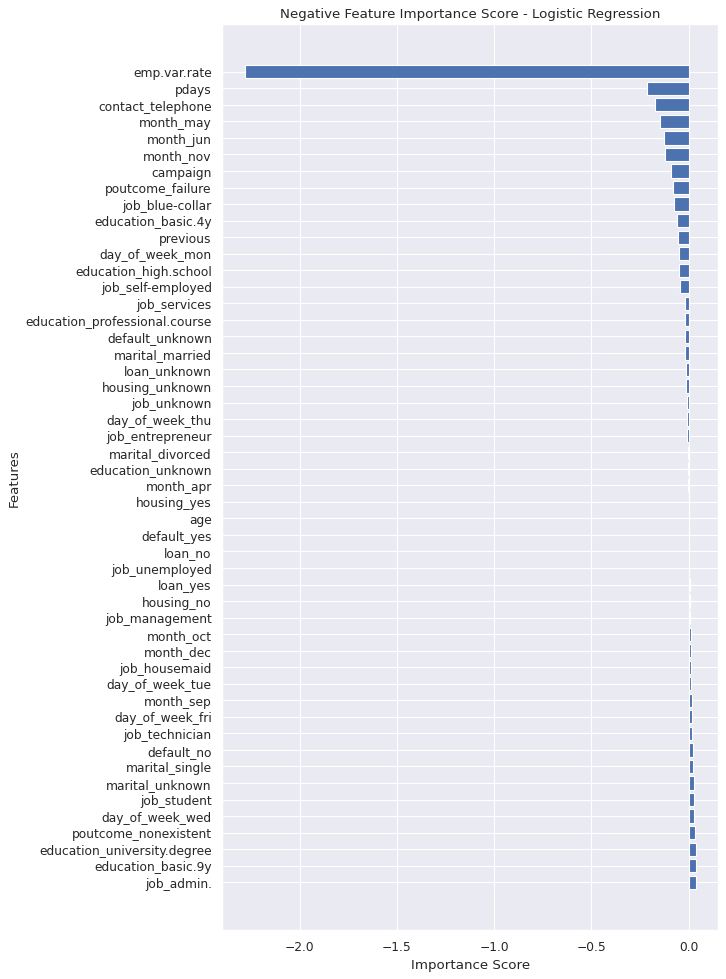

In [116]:
values_to_plot = feature_importances.iloc[-num:].values.ravel()
feature_labels = list(feature_importances.iloc[-num:].index)

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, feature_labels)
plt.show()

In the case of high variance, one strategy is to reduce the number of variables to minimize overfitting. After this analyis, you could use the top N positive and negative features or the top N important random forest features. You might need to adjust N so that your performance does not drop drastically.

### Random Forest

In [117]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

RandomForestClassifier(max_depth=6, random_state=42)

In [118]:
feature_importances = pd.DataFrame(rf.feature_importances_,
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
nr.employed,0.196858
euribor3m,0.176765
emp.var.rate,0.118171
cons.conf.idx,0.085807
cons.price.idx,0.062517


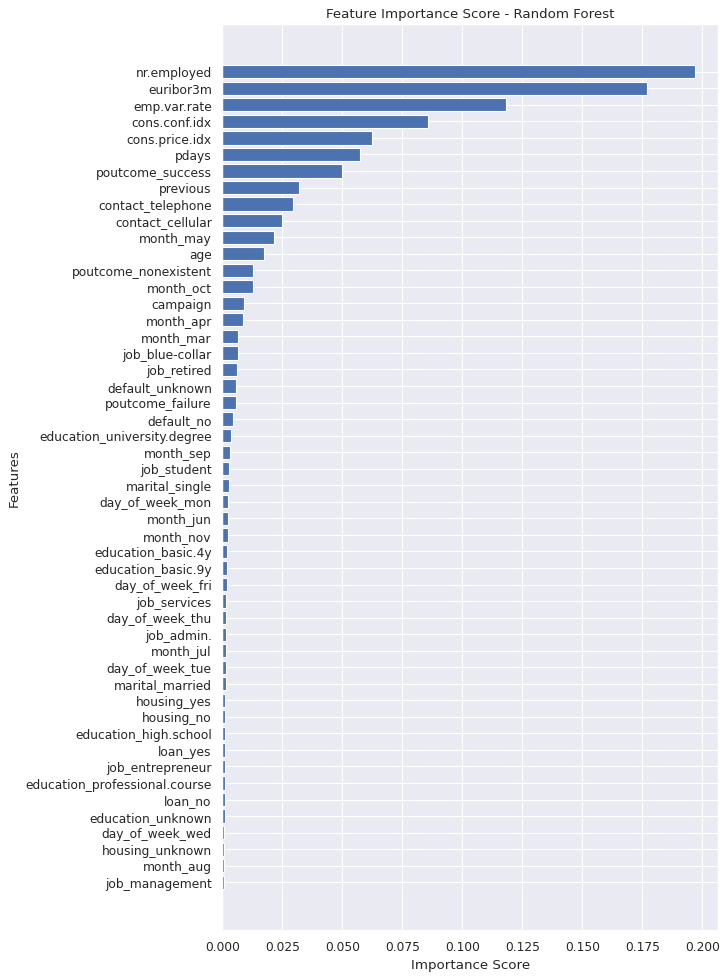

In [119]:
num = np.min([50, len(cols_input)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

### Gradient Boosting Classifier


In [120]:
gbc=GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [121]:
feature_importances = pd.DataFrame(gbc.feature_importances_,
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
nr.employed,0.441158
euribor3m,0.119302
cons.price.idx,0.090735
age,0.070406
campaign,0.031710


I realized the features that have more positive impact on the predictive outcomes of the model: euribor3m (3 month rate - daily indicator) and age are very crucial as their importance score is higher than other numerical variables.

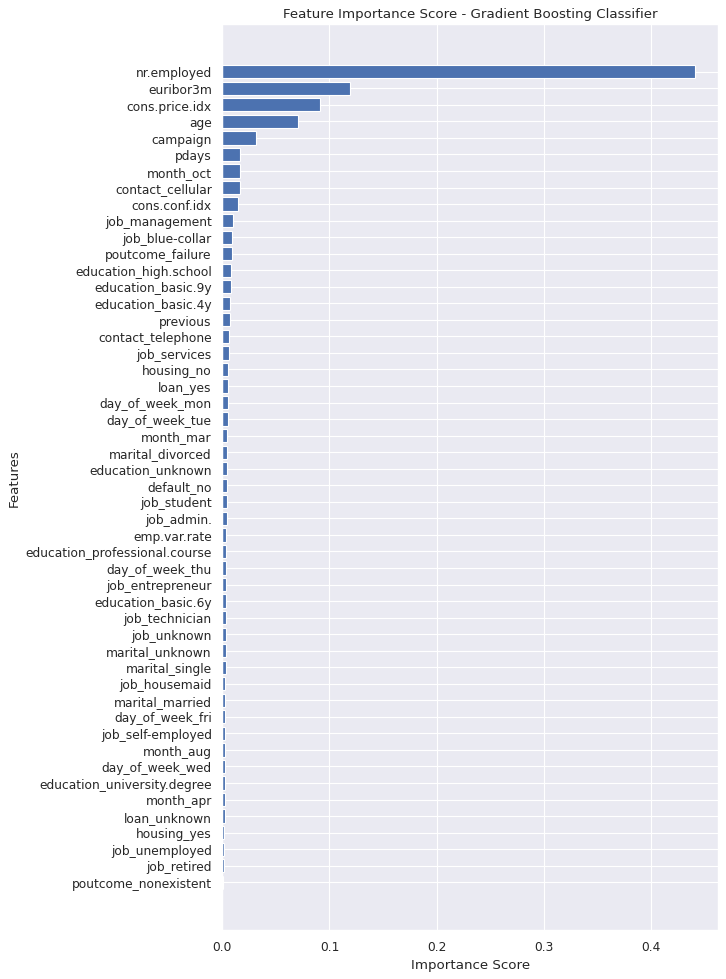

In [122]:
num = np.min([50, len(cols_input)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Gradient Boosting Classifier')
plt.yticks(ylocs, feature_labels)
plt.show()

### Decision Trees


In [123]:
tree = DecisionTreeClassifier(max_depth = 10, random_state = 42)
tree.fit(X_train_tf, y_train)

DecisionTreeClassifier(max_depth=10, random_state=42)

In [124]:
feature_importances = pd.DataFrame(tree.feature_importances_,
                                   index = cols_input,
                                    columns=['importance']).sort_values('importance',
                                                                        ascending=False)
feature_importances.head()

,importance
nr.employed,0.476284
cons.price.idx,0.092721
euribor3m,0.086205
age,0.062884
campaign,0.035954


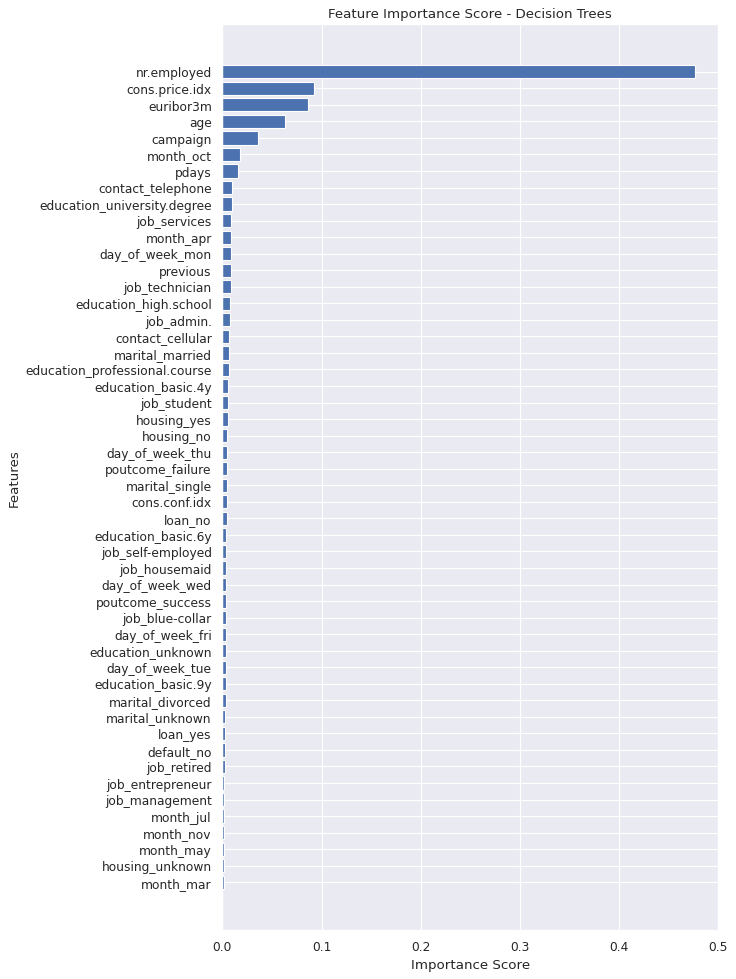

In [125]:
num = np.min([50, len(cols_input)])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]

plt.figure(num=None, figsize=(8, 15), dpi=80, facecolor='w', edgecolor='k');
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score - Decision Trees')
plt.yticks(ylocs, feature_labels)
plt.show()

According to provided analysis we can say that the most important features are related to economic indicators. Moreover, individual characteristics such as education level or having a loan are not so important. 

However, we should be skeptical for these predictions as there are some strange 'important' features such as October or Wednesday

## Hyperparameter tuning


A hyperparameter is a tool used in machine learning in order to estimate the model parameters (used in tuning a predictive modeling problem).  Hyperparameters are used in various machine learning algorithms. 

In [126]:
# train a model for each max_depth in a list. Store the auc for the training and validation set

# max depths
max_depths = np.arange(2,20,2)

train_aucs = np.zeros(len(max_depths))
valid_aucs = np.zeros(len(max_depths))

for jj in range(len(max_depths)):
    max_depth = max_depths[jj]

    # fit model
    rf=RandomForestClassifier(n_estimators = 100, max_depth = max_depth, random_state = 42)
    rf.fit(X_train_tf, y_train)        
    # get predictions
    y_train_preds = rf.predict_proba(X_train_tf)[:,1]
    y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

    # calculate auc
    auc_train = roc_auc_score(y_train, y_train_preds)
    auc_valid = roc_auc_score(y_valid, y_valid_preds)

    # save aucs
    train_aucs[jj] = auc_train
    valid_aucs[jj] = auc_valid

n_estimators is a hyperparameter in the RandomForestClassifier that depending on the numbers of estimators entered the model can be overfitted, good compromise or underfitted. n_estimators is used for fine tuning the models in order to fit the training data. max_depth is also another hyperparameter; it controls the depth of the machine learning algorithm model.

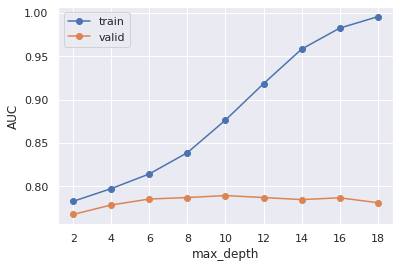

In [127]:
plt.plot(max_depths, train_aucs,'o-',label = 'train')
plt.plot(max_depths, valid_aucs,'o-',label = 'valid')

plt.xlabel('max_depth')
plt.ylabel('AUC')
plt.legend()
plt.show()

Using RandomizedSearchCV to optimize a few of the baseline models. Gradient Boosting Classifier may take a while so one might need to adjust the number of iterations or specific parameters. If this takes too long on the computer, one can take it out.

In [128]:
rf.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 18,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

In [129]:
# number of trees
n_estimators = range(200,1000,200)
# maximum number of features to use at each split
max_features = ['auto','sqrt']
# maximum depth of the tree
max_depth = range(2,20,2)
# minimum number of samples to split a node
min_samples_split = range(2,10,2)
# criterion for evaluating a split
criterion = ['gini','entropy']

# random grid

random_grid = {'n_estimators':n_estimators,
              'max_features':max_features,
              'max_depth':max_depth,
              'min_samples_split':min_samples_split,
              'criterion':criterion}

print(random_grid)

{'n_estimators': range(200, 1000, 200), 'max_features': ['auto', 'sqrt'], 'max_depth': range(2, 20, 2), 'min_samples_split': range(2, 10, 2), 'criterion': ['gini', 'entropy']}


In [130]:
auc_scoring = make_scorer(roc_auc_score)

In [131]:
# create a baseline model
rf = RandomForestClassifier()

# create the randomized search cross-validation
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 20, cv = 2, 
                               scoring=auc_scoring,verbose = 1, random_state = 42)

In [132]:
import time
# fit the random search model (this will take a few minutes)
t1 = time.time()
rf_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

Fitting 2 folds for each of 20 candidates, totalling 40 fits
91.73003125190735


See the best parameters

In [133]:
rf_random.best_params_

{'n_estimators': 600,
 'min_samples_split': 6,
 'max_features': 'auto',
 'max_depth': 16,
 'criterion': 'gini'}

In [134]:
rf=RandomForestClassifier(max_depth = 6, random_state = 42)
rf.fit(X_train_tf, y_train)

y_train_preds = rf.predict_proba(X_train_tf)[:,1]
y_valid_preds = rf.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline Random Forest')
rf_train_base_auc = roc_auc_score(y_train, y_train_preds)
rf_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)


print('Training:')
rf_train_auc, rf_train_accuracy, rf_train_recall, rf_train_precision, rf_train_specificity, rf_train_f1 =print_report(y_train,y_train_preds, thresh)
print('Validation:')
rf_valid_auc, rf_valid_accuracy, rf_valid_recall, rf_valid_precision, rf_valid_specificity, rf_valid_f1 = print_report(y_valid,y_valid_preds, thresh)



print('Optimized Random Forest')
y_train_preds_random = rf_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = rf_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
rf_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
rf_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training:')
rf_train_opt_auc, rf_train_opt_accuracy, rf_train_opt_recall, rf_train_opt_precision, rf_train_opt_specificity, rf_train_opt_f1 =print_report(y_train,y_train_preds_random, thresh)
print('Validation:')
rf_valid_opt_auc, rf_valid_opt_accuracy, rf_valid_opt_recall, rf_valid_opt_precision, rf_valid_opt_specificity, rf_valid_opt_f1 = print_report(y_valid,y_valid_preds_random, thresh)



Baseline Random Forest
Training:
AUC:0.814
accuracy:0.752
recall:0.647
precision:0.819
specificity:0.857
prevalence:0.500
f1:0.723
 
Validation:
AUC:0.785
accuracy:0.732
recall:0.620
precision:0.800
specificity:0.845
prevalence:0.500
f1:0.699
 
Optimized Random Forest
Training:
AUC:0.952
accuracy:0.831
recall:0.739
precision:0.906
specificity:0.923
prevalence:0.500
f1:0.814
 
Validation:
AUC:0.788
accuracy:0.736
recall:0.621
precision:0.806
specificity:0.851
prevalence:0.500
f1:0.702
 


Optimized SGDClassifier

In [135]:
sgdc=SGDClassifier(loss = 'log',alpha = 0.1,random_state = 42)
sgdc.fit(X_train_tf, y_train)

SGDClassifier(alpha=0.1, loss='log', random_state=42)

In [136]:
penalty = ['none','l2','l1']
max_iter = range(200,1000,200)
alpha = [0.001,0.003,0.01,0.03,0.1,0.3]
random_grid_sgdc = {'penalty':penalty,
              'max_iter':max_iter,
              'alpha':alpha}
# create the randomized search cross-validation
sgdc_random = RandomizedSearchCV(estimator = sgdc, param_distributions = random_grid_sgdc, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, random_state = 42)

t1 = time.time()
sgdc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

3.7535696029663086


In [137]:
sgdc_random.best_params_

{'penalty': 'l2', 'max_iter': 400, 'alpha': 0.01}

In [138]:
y_train_preds = sgdc.predict_proba(X_train_tf)[:,1]
y_valid_preds = sgdc.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline sgdc')
sgdc_train_base_auc = roc_auc_score(y_train, y_train_preds)
sgdc_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training:')
sgdc_train_auc, sgdc_train_accuracy, sgdc_train_recall, sgdc_train_precision, sgdc_train_specificity, sgdc_train_f1 =print_report(y_train,y_train_preds, thresh)
print('Validation:')
sgdc_valid_auc, sgdc_valid_accuracy, sgdc_valid_recall, sgdc_valid_precision, sgdc_valid_specificity, sgdc_valid_f1 = print_report(y_valid,y_valid_preds, thresh)


print('Optimized sgdc')
y_train_preds_random = sgdc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = sgdc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
sgdc_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
sgdc_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_random)


print('Training:')
sgdc_train_opt_auc, sgdc_train_opt_accuracy, sgdc_train_opt_recall, sgdc_train_opt_precision, sgdc_train_opt_specificity, sgdc_train_opt_f1 =print_report(y_train,y_train_preds_random, thresh)
print('Validation:')
sgdc_valid_opt_auc, sgdc_valid_opt_accuracy, sgdc_valid_opt_recall, sgdc_valid_opt_precision, sgdc_valid_opt_specificity, sgdc_valid_opt_f1 = print_report(y_valid,y_valid_preds_random, thresh)


Baseline sgdc
Training:
AUC:0.794
accuracy:0.741
recall:0.654
precision:0.793
specificity:0.829
prevalence:0.500
f1:0.717
 
Validation:
AUC:0.778
accuracy:0.732
recall:0.635
precision:0.789
specificity:0.830
prevalence:0.500
f1:0.703
 
Optimized sgdc
Training:
AUC:0.795
accuracy:0.743
recall:0.645
precision:0.803
specificity:0.842
prevalence:0.500
f1:0.715
 
Validation:
AUC:0.779
accuracy:0.732
recall:0.620
precision:0.800
specificity:0.845
prevalence:0.500
f1:0.699
 


Optimized Gradient Boosting Classifier

In [139]:
from sklearn.ensemble import GradientBoostingClassifier
gbc =GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
     max_depth=3, random_state=42)
gbc.fit(X_train_tf, y_train)

GradientBoostingClassifier(learning_rate=1.0, random_state=42)

In [140]:
# number of trees
n_estimators = range(50,200,50)

# maximum depth of the tree
max_depth = range(1,5,1)

# learning rate
learning_rate = [0.001,0.01,0.1]

# random grid

random_grid_gbc = {'n_estimators':n_estimators,
              'max_depth':max_depth,
              'learning_rate':learning_rate}

# create the randomized search cross-validation
gbc_random = RandomizedSearchCV(estimator = gbc, param_distributions = random_grid_gbc, n_iter = 20, cv = 2, scoring=auc_scoring,verbose = 0, random_state = 42)

t1 = time.time()
gbc_random.fit(X_train_tf, y_train)
t2 = time.time()
print(t2-t1)

23.406189441680908


In [141]:
gbc_random.best_params_

{'n_estimators': 150, 'max_depth': 2, 'learning_rate': 0.1}

In [142]:
y_train_preds = gbc.predict_proba(X_train_tf)[:,1]
y_valid_preds = gbc.predict_proba(X_valid_tf)[:,1]

thresh = 0.5

print('Baseline gbc')
gbc_train_base_auc = roc_auc_score(y_train, y_train_preds)
gbc_valid_base_auc = roc_auc_score(y_valid, y_valid_preds)

print('Training:')
gbc_train_auc, gbc_train_accuracy, gbc_train_recall, gbc_train_precision, gbc_train_specificity, gbc_train_f1 =print_report(y_train,y_train_preds, thresh)
print('Validation:')
gbc_valid_auc, gbc_valid_accuracy, gbc_valid_recall, gbc_valid_precision, gbc_valid_specificity, gbc_valid_f1 = print_report(y_valid,y_valid_preds, thresh)

print('Optimized gbc')
y_train_preds_random = gbc_random.best_estimator_.predict_proba(X_train_tf)[:,1]
y_valid_preds_random = gbc_random.best_estimator_.predict_proba(X_valid_tf)[:,1]
gbc_train_opt_auc = roc_auc_score(y_train, y_train_preds_random)
gbc_valid_opt_auc = roc_auc_score(y_valid, y_valid_preds_random)

print('Training:')
gbc_train_opt_auc, gbc_train_opt_accuracy, gbc_train_opt_recall, gbc_train_opt_precision, gbc_train_opt_specificity, gbc_train_opt_f1 =print_report(y_train,y_train_preds_random, thresh)
print('Validation:')
gbc_valid_opt_auc, gbc_valid_opt_accuracy, gbc_valid_opt_recall, gbc_valid_opt_precision, gbc_valid_opt_specificity, gbc_valid_opt_f1 = print_report(y_valid,y_valid_preds_random, thresh)

Baseline gbc
Training:
AUC:0.901
accuracy:0.819
recall:0.751
precision:0.869
specificity:0.887
prevalence:0.500
f1:0.806
 
Validation:
AUC:0.752
accuracy:0.707
recall:0.638
precision:0.740
specificity:0.775
prevalence:0.500
f1:0.685
 
Optimized gbc
Training:
AUC:0.813
accuracy:0.752
recall:0.651
precision:0.816
specificity:0.853
prevalence:0.500
f1:0.724
 
Validation:
AUC:0.783
accuracy:0.733
recall:0.619
precision:0.802
specificity:0.847
prevalence:0.500
f1:0.699
 


## Optimized Results

In [143]:
df_results = pd.DataFrame({'classifier':['SGD','SGD','RF','RF','GB','GB'],
                           'data_set':['baseline','optimized']*3,
                          'f1':[sgdc_valid_f1,sgdc_valid_opt_f1,
                                 rf_valid_f1,rf_valid_opt_f1,
                                 gbc_valid_f1,gbc_valid_opt_f1],
                          })
df_results

,classifier,data_set,f1
0,SGD,baseline,0.703430
1,SGD,optimized,0.698565
2,RF,baseline,0.698565
3,RF,optimized,0.701851
4,GB,baseline,0.685342
5,GB,optimized,0.698630


Comparing the performance of the optimized models to the baseline models. 

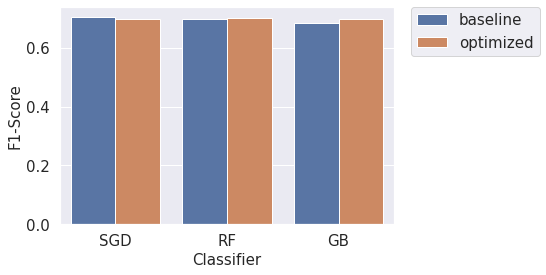

In [144]:
sns.set(style="darkgrid")
ax = sns.barplot(x="classifier", y="f1", hue="data_set", data=df_results)
ax.set_xlabel('Classifier',fontsize = 15)
ax.set_ylabel('F1-Score', fontsize = 15)
ax.tick_params(labelsize=15)
# Put the legend out of the figure
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize = 15)

plt.show()

## Picking the best model

We picked Gradient Boosting optimized version as the best model because the optimized version has a higher f1-score than the baseline and optimized models of Stochastic Gradient Descent and Random Forest

In [145]:
pickle.dump(gbc_random.best_estimator_, open('best_classifier.pkl', 'wb'),protocol = 4)

# Predictions

In [146]:
# load the model, columns, mean values, and scaler
best_model = pickle.load(open('best_classifier.pkl','rb'))
cols_input = pickle.load(open('cols_input.sav','rb'))
df_mean_in = pd.read_csv('df_mean.csv', names =['col','mean_val'])
scaler = pickle.load(open('scaler.sav', 'rb'))

In [147]:
# load the data
df_train = pd.read_csv('df_train.csv')
df_valid= pd.read_csv('df_valid.csv')

In [148]:
# fill missing
df_train = fill_my_missing(df_train, df_mean_in, cols_input)
df_valid = fill_my_missing(df_valid, df_mean_in, cols_input)


# create X and y matrices
X_train = df_train[cols_input].values
X_valid = df_valid[cols_input].values

y_train = df_train['y'].values
y_valid = df_valid['y'].values

# transform our data matrices 
X_train_tf = scaler.transform(X_train)
X_valid_tf = scaler.transform(X_valid)

In [149]:
test = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/test_data.csv')
test = pd.get_dummies(test)
test.insert(34, "default_yes", 0, True)
df_test = test[cols_input]
df_test.head()

,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,nr.employed,age,euribor3m,job_admin.,...,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
0,1,999,0,1.1,93.994,-36.4,5191.0,37,4.857,0,...,0,0,0,1,0,0,0,0,1,0
1,1,999,0,1.1,93.994,-36.4,5191.0,46,4.857,0,...,0,0,0,1,0,0,0,0,1,0
2,1,999,0,1.1,93.994,-36.4,5191.0,39,4.857,0,...,0,0,0,1,0,0,0,0,1,0
3,1,999,0,1.1,93.994,-36.4,5191.0,35,4.857,0,...,0,0,0,1,0,0,0,0,1,0
4,1,999,0,1.1,93.994,-36.4,5191.0,41,4.857,1,...,0,0,0,1,0,0,0,0,1,0


In [150]:
y_test_preds = gbc_random.predict(df_test)

In [151]:
y_test_preds.astype(str)

array(['0', '0', '0', ..., '1', '1', '1'], dtype='<U21')

In [152]:
submissions = pd.read_csv("/kaggle/input/part-of-your-final-course-grade/submission1")

In [153]:
submissions['y'] = y_test_preds

In [154]:
submissions = submissions.astype(str)

In [155]:
submissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      4119 non-null   object
 1   y       4119 non-null   object
dtypes: object(2)
memory usage: 64.5+ KB


In [156]:
submissions.to_csv('submission1.csv', sep = ',', index = False)

# Appendix: Alterantive ways to resample dataset

Unfortunately, here we have the bad proportion of FP and FN predictions. The more clients we predict as already have subscriptions and not call them (big FP). But this is a bad way, we miss potential clients. It is better if we call by mistake clients (big FN), who already have a subscription. They just decline the proposal


In [157]:
test = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/test_data.csv')
train = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/train_data.csv')

# As we have problems with 'duration'
# And 'emp.var.rate' is highly correlated with other values
train = train.drop(['duration', 'emp.var.rate'], axis = 1) 
test = test.drop(['duration', 'emp.var.rate'], axis = 1)

In [158]:
cols_cat = ['job', 'marital', 'education', 'default','housing', 
            'loan', 'contact', 'poutcome', 'month', 'day_of_week']
dummies_train = pd.get_dummies(train[cols_cat])
dummies_test = pd.get_dummies(test[cols_cat])

train_prepared = pd.concat([train, dummies_train],axis=1)
train_prepared = train_prepared.drop(cols_cat, axis = 1)

test_prepared = pd.concat([test, dummies_test],axis=1)
test_prepared = test_prepared.drop(cols_cat, axis = 1)

# Data normalization
train_prepared = (train_prepared - np.min(train_prepared)) / (np.max(train_prepared) - np.min(train_prepared)).values

In [159]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_prepared.drop(['y'], axis = 1), train_prepared['y'], test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)

(25948, 62)
(11121, 62)


### Oversampling method

In this case we duplicate the minority class by adding copies randomly. But the disadvantage of oversampling is that it causes overfitting and generalization of data

In [160]:
test = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/test_data.csv')
train = pd.read_csv('/kaggle/input/part-of-your-final-course-grade/train_data.csv')

# Drop duration as we have problems with this parameter
# Also drop highly correlated parameters 
train = train.drop(['duration', 'emp.var.rate', 'euribor3m'], axis = 1) 
test = test.drop(['duration', 'emp.var.rate', 'euribor3m'], axis = 1)

In [161]:
cols_cat = ['job', 'marital', 'education', 'default','housing', 
            'loan', 'contact', 'poutcome', 'month', 'day_of_week']
dummies_train = pd.get_dummies(train[cols_cat])
dummies_test = pd.get_dummies(test[cols_cat])

train_prepared = pd.concat([train, dummies_train],axis=1)
train_prepared = train_prepared.drop(cols_cat, axis = 1)

test_prepared = pd.concat([test, dummies_test],axis=1)
test_prepared = test_prepared.drop(cols_cat, axis = 1)

# Data normalization
train_prepared = (train_prepared - np.min(train_prepared)) / (np.max(train_prepared) - np.min(train_prepared)).values

In [162]:
X_train, X_test, y_train, y_test = train_test_split(train_prepared.drop(['y'], axis = 1), train_prepared['y'], test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)

(25948, 61)
(11121, 61)


In [163]:
X = pd.concat([X_train, y_train], axis=1)

# Separate classes
not_fraud = X[X.y==0]
fraud = X[X.y==1]

# Upsample minority
fraud_upsampled = resample(fraud,
                          replace=True,
                          n_samples=len(not_fraud), 
                          random_state=42)

upsampled = pd.concat([not_fraud, fraud_upsampled])
upsampled.y.value_counts()

0.0    23016
1.0    23016
Name: y, dtype: int64

In [164]:
y_train = upsampled.y
X_train = upsampled.drop('y', axis=1)

In [165]:
X_test.shape

(11121, 61)

In [166]:
upsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)
upsampled_pred = upsampled.predict(X_test)
score_f1 = f1_score(y_test, upsampled_pred, )
score_ac = accuracy_score(y_test, upsampled_pred)
print('F1-score of the Logistic Regression is %.2f' %(score_f1*100))
# Here we can see on both scores as the data is balanced
print('Accuracy of the Logistic Regression is %.2f' %(score_ac*100))

F1-score of the Logistic Regression is 44.98
Accuracy of the Logistic Regression is 82.60


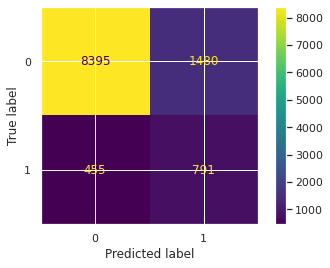

In [167]:
cm = confusion_matrix(y_test, upsampled_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [168]:
# Also estimate a Random Forest as it allows to work by learning a hierarchy
params = {
    'n_estimators': [10, 20, 30, 40, 50, 60],
    'max_depth': range(1, 50, 5),
    }

Random_Forest = RandomForestClassifier(n_jobs=4, criterion = 'entropy', 
                                       random_state=42)
grid_search = GridSearchCV(Random_Forest, params, cv = 5)
grid_search.fit(X_train, y_train)

grid = grid_search.best_estimator_
print('Best parameters found by randomised search:', grid_search.best_params_, '\n')

Best parameters found by randomised search: {'max_depth': 46, 'n_estimators': 10} 



In [169]:
result_RF = grid_search.predict(X_test)
score_RF = f1_score(y_test, result_RF)
print('F1-score of the Random Forest is %.2f' %(score_RF*100))
score_ac = accuracy_score(y_test, result_RF)
print('Accuracy of the Random Forest is %.2f' %(score_ac*100))


F1-score of the Random Forest is 42.00
Accuracy of the Random Forest is 88.63


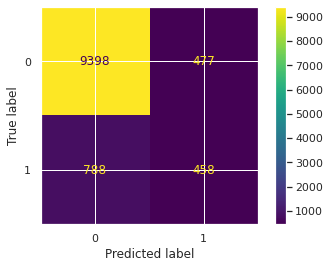

In [170]:
cm_RF = confusion_matrix(y_test, result_RF)
cm_display = ConfusionMatrixDisplay(cm_RF).plot()

In [171]:
test_prepared.insert(34, "default_yes", 0, True)
test_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            4119 non-null   int64  
 1   campaign                       4119 non-null   int64  
 2   pdays                          4119 non-null   int64  
 3   previous                       4119 non-null   int64  
 4   cons.price.idx                 4119 non-null   float64
 5   cons.conf.idx                  4119 non-null   float64
 6   nr.employed                    4119 non-null   float64
 7   id                             4119 non-null   int64  
 8   job_admin.                     4119 non-null   uint8  
 9   job_blue-collar                4119 non-null   uint8  
 10  job_entrepreneur               4119 non-null   uint8  
 11  job_housemaid                  4119 non-null   uint8  
 12  job_management                 4119 non-null   u

In [172]:
y_test_preds = grid_search.predict(test_prepared).astype(int)

In [173]:
y_test_preds

array([0, 0, 0, ..., 0, 0, 0])

In [174]:
submissions = pd.DataFrame()

In [175]:
submissions['id'] = test['id'].astype('string')
submissions['y'] = y_test_preds

In [176]:
submissions = submissions.astype('string')

In [177]:
submissions.to_csv('submission.csv', sep = ',', index = False)

### Undersampling method
In this case we remove some random observaions from the majority class. The disadvantage is that we will have a very few observations

In [178]:
not_fraud_downsampled = resample(not_fraud,
                                replace = False,
                                n_samples = len(fraud),
                                random_state = 42)

downsampled = pd.concat([not_fraud_downsampled, fraud])
downsampled.y.value_counts()

0.0    2932
1.0    2932
Name: y, dtype: int64

In [179]:
X_train, X_test, y_train, y_test = train_test_split(train_prepared.drop(['y'], axis = 1), train_prepared['y'], test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)

(25948, 61)
(11121, 61)


In [180]:
y_train = downsampled.y
X_train = downsampled.drop('y', axis=1)

downsampled = LogisticRegression(solver='liblinear').fit(X_train, y_train)
downsampled_pred = downsampled.predict(X_test)
score_f1 = f1_score(y_test, downsampled_pred)
score_ac = accuracy_score(y_test, downsampled_pred)
print('F1-score of the Logistic Regression is %.2f' %(score_f1*100))
print('Accuracy of the Logistic Regression is %.2f' %(score_ac*100))

F1-score of the Logistic Regression is 45.57
Accuracy of the Logistic Regression is 83.03


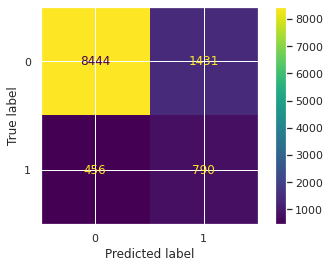

In [181]:
cm = confusion_matrix(y_test, downsampled_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [182]:
params = {
    'n_estimators': [10, 20, 30, 50, 60],
    'max_depth': range(1, 50, 5),
    }

Random_Forest = RandomForestClassifier(n_jobs=4, criterion = 'entropy', 
                                       random_state=42)
grid_search = GridSearchCV(Random_Forest, params, cv = 5)
grid_search.fit(X_train, y_train)

grid = grid_search.best_estimator_
print('Best parameters found by randomised search:', grid_search.best_params_, '\n')

Best parameters found by randomised search: {'max_depth': 11, 'n_estimators': 60} 



In [183]:
result_RF = grid_search.predict(X_test)
score_RF = f1_score(y_test, result_RF)
print('F1-score of the Random Forest is %.2f' %(score_RF*100))
score_ac = accuracy_score(y_test, result_RF)
print('Accuracy of the Random Forest is %.2f' %(score_ac*100))


F1-score of the Random Forest is 47.64
Accuracy of the Random Forest is 84.46


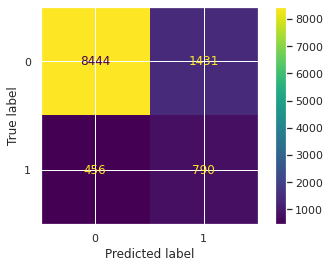

In [184]:
cm = confusion_matrix(y_test, downsampled_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [185]:
y_test_preds = grid_search.predict(test_prepared).astype(int)

In [186]:
y_test_preds

array([1, 1, 0, ..., 1, 1, 1])

In [187]:
submissions = pd.DataFrame()

In [188]:
submissions['id'] = test['id'].astype('string')
submissions['y'] = y_test_preds

In [189]:
submissions = submissions.astype('string')

In [190]:
submissions.to_csv('submission1_under.csv', sep = ',', index = False)

### SMOTE(Synthetic Minority Oversampling Technique)
In this case there is a KNN algorithm on the base to generate new and synthetic data we can use for training our model.

In [191]:
y = train_prepared.y
X = train_prepared.drop('y', axis=1)

# setting up testing and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=27)

sm = SMOTE(random_state=27)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [192]:
smote = LogisticRegression(solver='liblinear').fit(X_train, y_train)
smote_pred = smote.predict(X_test)

score_f1 = f1_score(y_test, smote_pred)
score_ac = accuracy_score(y_test, smote_pred)
print('F1-score of the Logistic Regression is %.2f' %(score_f1*100))
print('Accuracy of the Logistic Regression is %.2f' %(score_ac*100))

F1-score of the Logistic Regression is 41.98
Accuracy of the Logistic Regression is 80.91


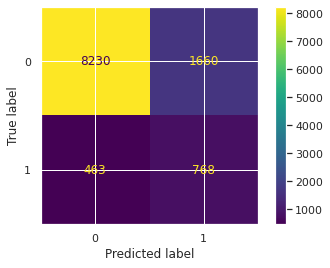

In [193]:
cm = confusion_matrix(y_test, smote_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [194]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=10).fit(X_train, y_train)
rfc_pred = rfc.predict(X_test)

score_f1 = f1_score(y_test, rfc_pred)
score_ac = accuracy_score(y_test, rfc_pred)
print('F1-score of the Random Forest is %.2f' %(score_f1*100))
print('Accuracy of the Random Forest is %.2f' %(score_ac*100))

F1-score of the Random Forest is 48.27
Accuracy of the Random Forest is 86.68


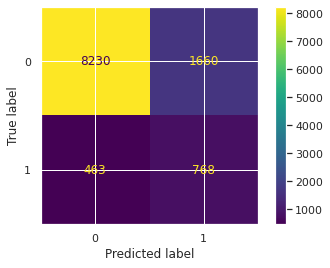

In [195]:
cm = confusion_matrix(y_test, smote_pred)
cm_display = ConfusionMatrixDisplay(cm).plot()

In [196]:
y_test_preds = rfc.predict(test_prepared).astype(int)

In [197]:
y_test_preds

array([0, 0, 0, ..., 1, 0, 1])

In [198]:
submissions = pd.DataFrame()

In [199]:
submissions['id'] = test['id'].astype('string')
submissions['y'] = y_test_preds

In [200]:
submissions = submissions.astype('string')

In [201]:
submissions.to_csv('submission1_smote.csv', sep = ',', index = False)